In [1]:
options(warn=-1)
library(tidyverse)
library(data.table)
library(keras)
library(tfruns)


-- Attaching packages --------------------------------------- tidyverse 1.3.0 --

v ggplot2 3.3.0     v purrr   0.3.4
v tibble  3.0.1     v dplyr   0.8.5
v tidyr   1.0.2     v stringr 1.4.0
v readr   1.3.1     v forcats 0.5.0

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()


Attaching package: 'data.table'


The following objects are masked from 'package:dplyr':

    between, first, last


The following object is masked from 'package:purrr':

    transpose




# Multi-Population Mortality Modeling With Neural Networks


## Table of Contents
1. [Import the Data Set](#0_import)
2. [Exploratory Data Analysis](#1_EDA) 
3. [Data Preprocessing](#2_data_processing)
4. [Prepare Training and Test Data for the Neural Network](#3_prepareNN)
5. [Set Up the Neural Network Architechture](#4_architecture)
6. [Predict and Project Mortality With Neural Network](#5_predictNN)
7. [Predict Mortality on Test Data With Lee-Carter Model](#6_predictLC)
8. [Compare Lee-Carter and Neural Network Mortality Predictions](#7_compare)


The point of departure for our training of neural networks is the article "A Neural Network Extension of the Lee-Carter Model to Multiple Populations", Richman and Wüthrich (2018). We build upon the method and model presented there and extend it by looking at different datasets and introducing a hyperparameter search.

This use case was developed for the Working Group Statistical Methods within the Committee Actuarial Data Science of German Actuarial Association.


# 1. Import the Data Set <a name="0_import"></a>

The mortality datasets used in this Use Case are extracted from Human Demography Database, covering mortality rates for the following 11 countries or regions as listed in the following vector
c('CHE', 'DEUT','DEUTE','DEUTW','DNK','ESP','FRATNP','ITA','JPN','POL', 'USA'). 

Data are included for both women and men from age 0 to 100. Due to certain underlying data idiosyncrasies we have imputated the missing values and zero values for mortality rates with their group average. Furthermore, we have not allowed mortalities larger than 100% in the data.

The provided data set is an integral part of our use case.
 

In [2]:

dta <- read.csv(file="mortality.csv")

## Print 10 random observations from the mortality dataset for an assessment of the plausibility of the data

sample_n(dta, 10)


Country,year,Gender,Age,log_mortality
FRATNP,1977,Male,61,-3.904005
USA,1977,Female,56,-4.946816
DEUTW,1990,Male,21,-6.792642
POL,1991,Female,77,-2.808009
ESP,1970,Male,0,-3.431605
DEUTW,1965,Male,70,-2.892670
FRATNP,1997,Female,46,-6.237877
DEUT,1958,Female,40,-6.212610
ITA,2007,Female,48,-6.586397
ESP,1970,Male,37,-6.085336


In our dataset, we include three mortality series for Germany: 
* DEUTE for Eastern Germany, 
* DEUTW for Western Germany, and 
* DEUT for Germany.

The mortality rates for the entire population of Germany (DEUT) were obtained by merging the mortality rates for West Germany (DEUTW) and East Germany (DEUTE) from 1956 to 1991, and the mortality rates for the re-unified Germany from 1993 to 2016. In this notebook we train the neural networks and Lee-Carter model for DEUT. Our notebook can be easily changed in order to use DEUTE and DEUTW instead of DEUT, in case the differences in the mortality rates in East and West Germany are of interest.

In [3]:
dta <- dta %>% mutate(mortality=exp(log_mortality))

data <- dplyr::filter(dta,Country%in%c("CHE","DEUT","DNK", "ESP", "FRATNP", "ITA", "JPN", "POL", "USA"))

In [4]:
sample_n(data,6)

## We show both log mortality and mortality values

Country,year,Gender,Age,log_mortality,mortality
DEUT,1978,Female,59,-4.884752,0.007561
POL,1968,Female,38,-6.494322,0.001512
POL,2015,Male,12,-8.668016,0.000172
USA,1993,Female,91,-1.805216,0.164439
ITA,1976,Male,28,-6.906756,0.001001
JPN,1956,Female,40,-5.760670,0.003149


# 2. Exploratory Data Analysis <a name="1_EDA"></a>

This chapter offers an exploratory data anaysis of the mortality dataset imported in Chapter 1. From the graphs plotted in this chapter, the readers will gain some insights about how the mortality rates differ between genders, across countries, with ages, and over time.

A few already well-known facts among actuaries can be observed here: 
* mortality rates by age decline over time, indicating an increase in life expectancy over time 
* mortality rates by age are lower for females than for males  
* countries show similar but still distinguishable pattern of mortality-age developments (see next section)

We encourage the readers to produce further comparisons using our template.

## 2.1 A First Look at the Mortality Rates by Age for Two Countries (Japan und US)

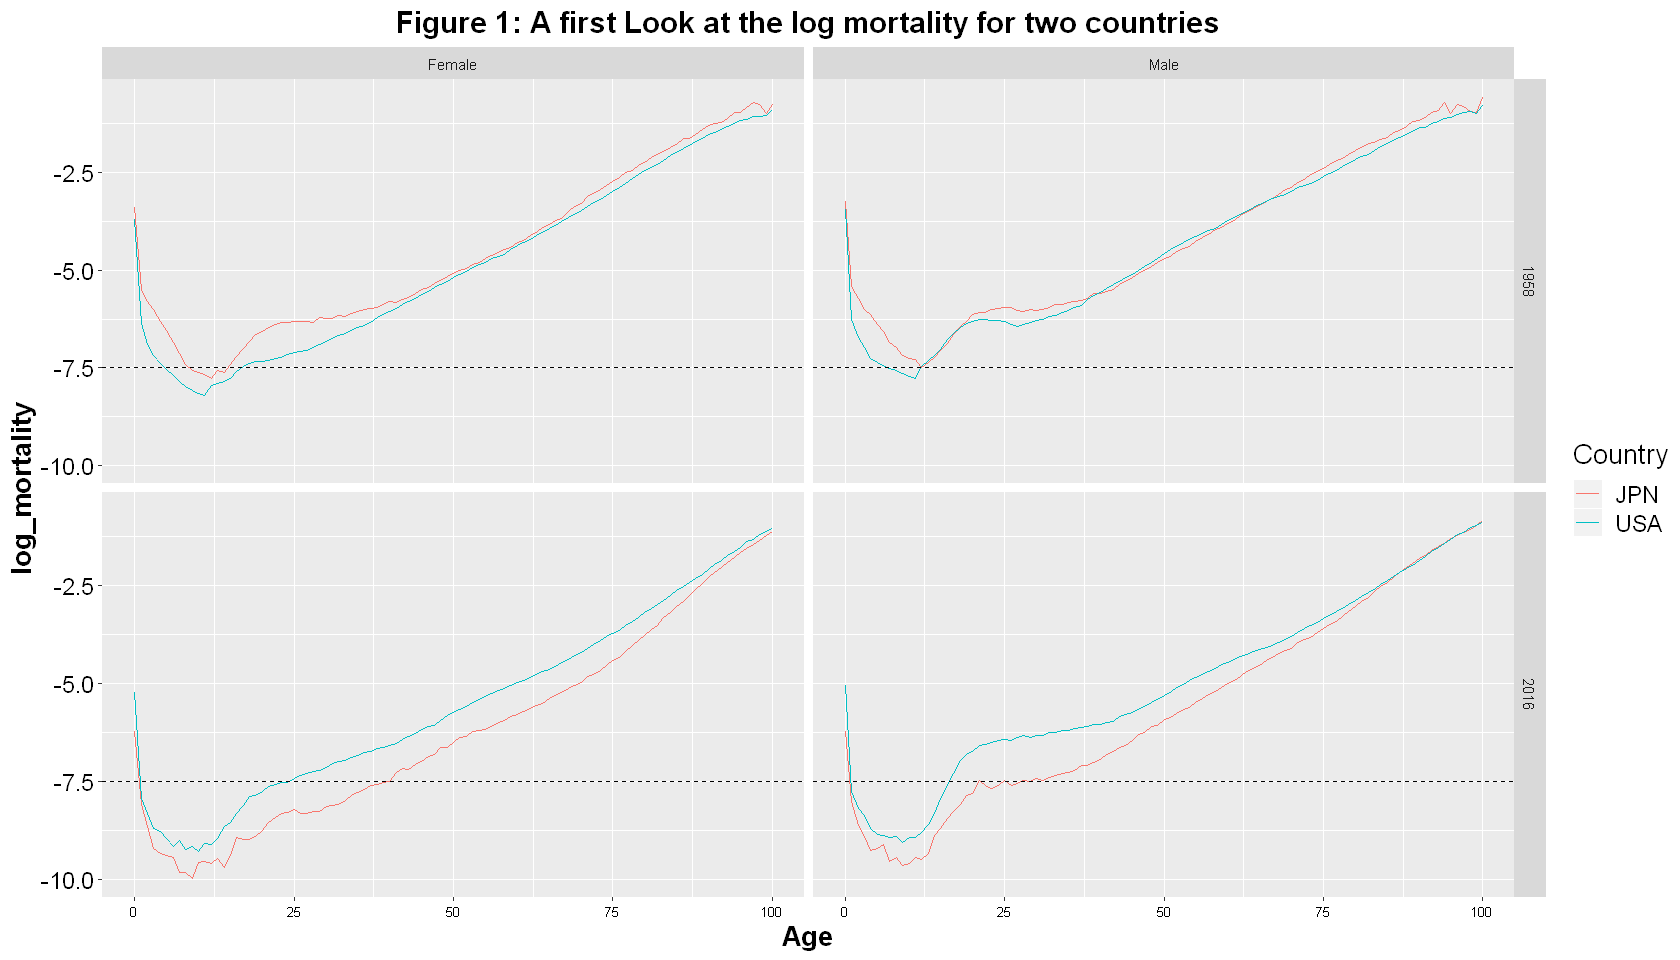

In [5]:

options(repr.plot.width = 14, repr.plot.height = 8)
ggplot(data[which(data$Year %in% c(1958,2016) & data$Country %in% c("JPN","USA")),], aes(Age, log_mortality, color=Country)) + 
  geom_line() + 
  geom_hline(yintercept=-7.5,col="black",lty=2) +
  facet_grid(Year ~ Gender)+
ggtitle("Figure 1: A first Look at the log mortality for two countries")+
theme(plot.title = element_text(color="black", size=18, hjust = 0.5 , face="bold"),
     legend.title = element_text(color = "black", size = 16),
        legend.text = element_text(color = "black", size = 14),
       axis.text.x = element_text(face="plain", color="black", 
                           size=8, angle=0),
          axis.text.y = element_text(face="plain", color="black", 
                           size=14, angle=0),
        axis.title.x=element_text(size=16,face="bold"),
      axis.title.y=element_text(size=16,face="bold")
     ) 

## 2.2 Mortality Rates by Age and Gender for All Countries From 1956 to 2016 


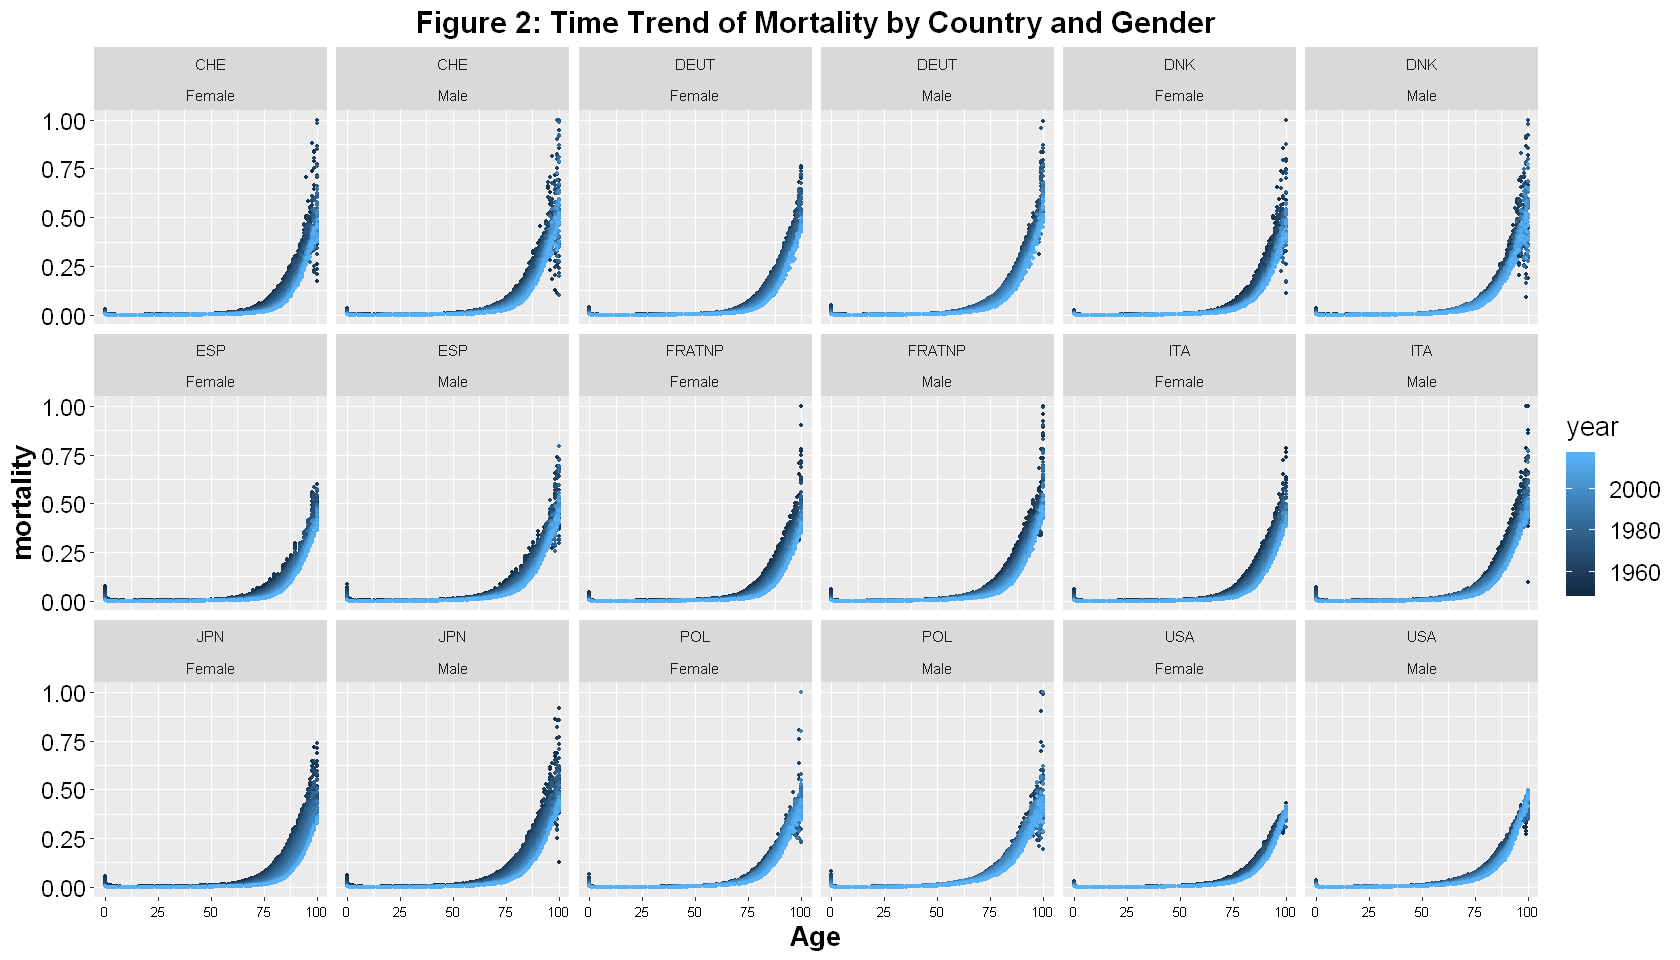

In [6]:
options(repr.plot.width = 14, repr.plot.height = 8)
ggplot(data,aes(Age,mortality,color=Year))+
geom_point(size=0.8)+
facet_wrap(~Country+Gender,ncol=6)+
ggtitle("Figure 2: Time Trend of Mortality by Country and Gender")+
theme(plot.title = element_text(color="black", size=18, hjust = 0.5 , face="bold"),
     legend.title = element_text(color = "black", size = 16),
        legend.text = element_text(color = "black", size = 14),
       axis.text.x = element_text(face="plain", color="black", 
                           size=8, angle=0),
          axis.text.y = element_text(face="plain", color="black", 
                           size=14, angle=0),
        axis.title.x=element_text(size=16,face="bold"),
      axis.title.y=element_text(size=16,face="bold")
     ) 

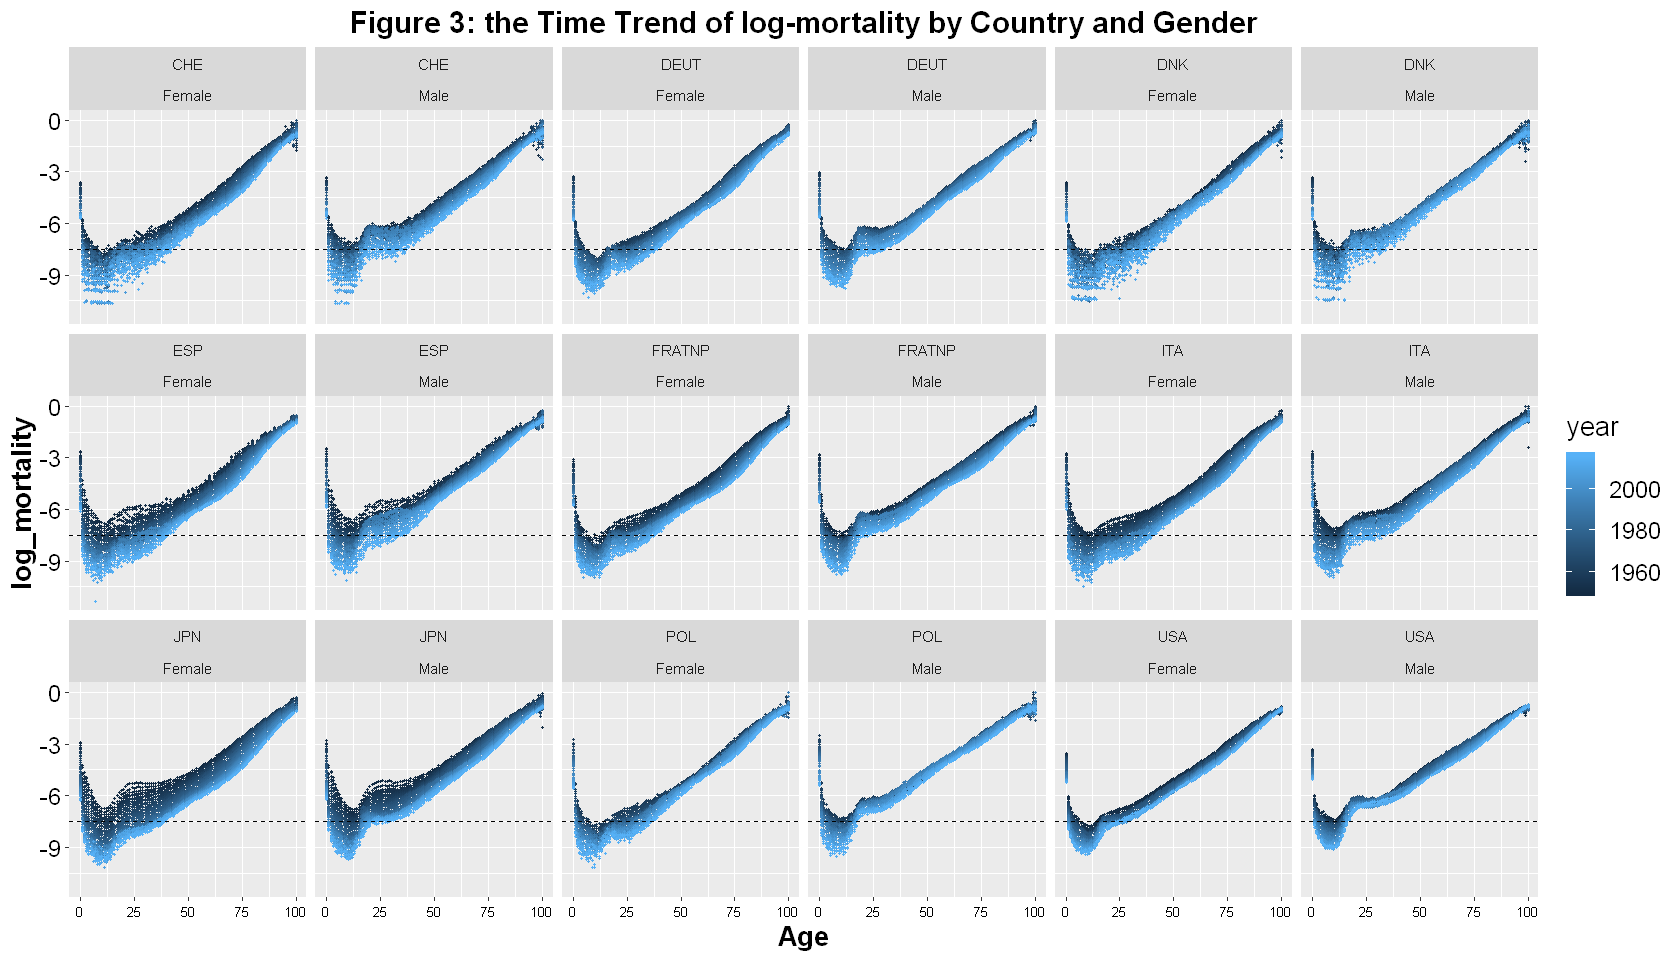

In [7]:
options(repr.plot.width = 14, repr.plot.height = 8)
data%>%ggplot(aes(Age,log_mortality,color=Year))+
geom_point(size=0.6)+
geom_hline(yintercept=-7.5,col="black",lty=2) +
facet_wrap(~Country+Gender,ncol=6)+
ggtitle("Figure 3: the Time Trend of log-mortality by Country and Gender")+
 theme(plot.title = element_text(color="black", size=18, hjust = 0.5,face="bold"),
     legend.title = element_text(color = "black", size = 16),
        legend.text = element_text(color = "black", size = 14),
       axis.text.x = element_text(face="plain", color="black", 
                           size=8, angle=0),
          axis.text.y = element_text(face="plain", color="black", 
                           size=14, angle=0),
        axis.title.x=element_text(size=16,face="bold"),
      axis.title.y=element_text(size=16,face="bold")
     ) 

## 2.3 Display Log Mortality for East Germany and West Germany by Age and Gender Using Heatmap

We start we a hint on how to interpret the colors in the heatmap: 
* The gradual changes in colors from red, green to blue are used to show the decrease in log mortality for younger people.
* The curves marked with a value are contours connecting points with the same log mortality rates. These contours are upward-sloping, therefore indicating that mortality rates by age are decreasing with time. 

In [8]:
myHeatmap <- function(country,gender) {
  Year.min <- 1958
  Year.max <- 2016
  hmrsel <- dta[which(dta$Country == country & dta$Gender == gender),]
  m0 <- c(min(hmrsel$log_mortality), max(hmrsel$log_mortality)) 
  # rows are calendar Year t, columns are ages x 
  log_mortality <- t(matrix(as.matrix(hmrsel[which(hmrsel$Gender==gender),"log_mortality"]), nrow=101, ncol=(Year.max-Year.min+1) ))
  image(z=log_mortality, useRaster=TRUE,  zlim=m0, col=rev(rainbow(n=60, start=0, end=.72)), xaxt='n', yaxt='n', main=list(paste( "log-mortality rates:",country, gender, sep=" "), cex=1.5), cex.lab=1.5, ylab="age x", xlab="calendar Year t") 
  axis(1, at=c(0:(Year.max-Year.min))/(Year.max-Year.min), c(Year.min:Year.max))                    
  axis(2, at=c(0:49)/50, labels=c(0:49)*2)   
  contour(z=log_mortality, add = TRUE, drawlabels = TRUE)
}

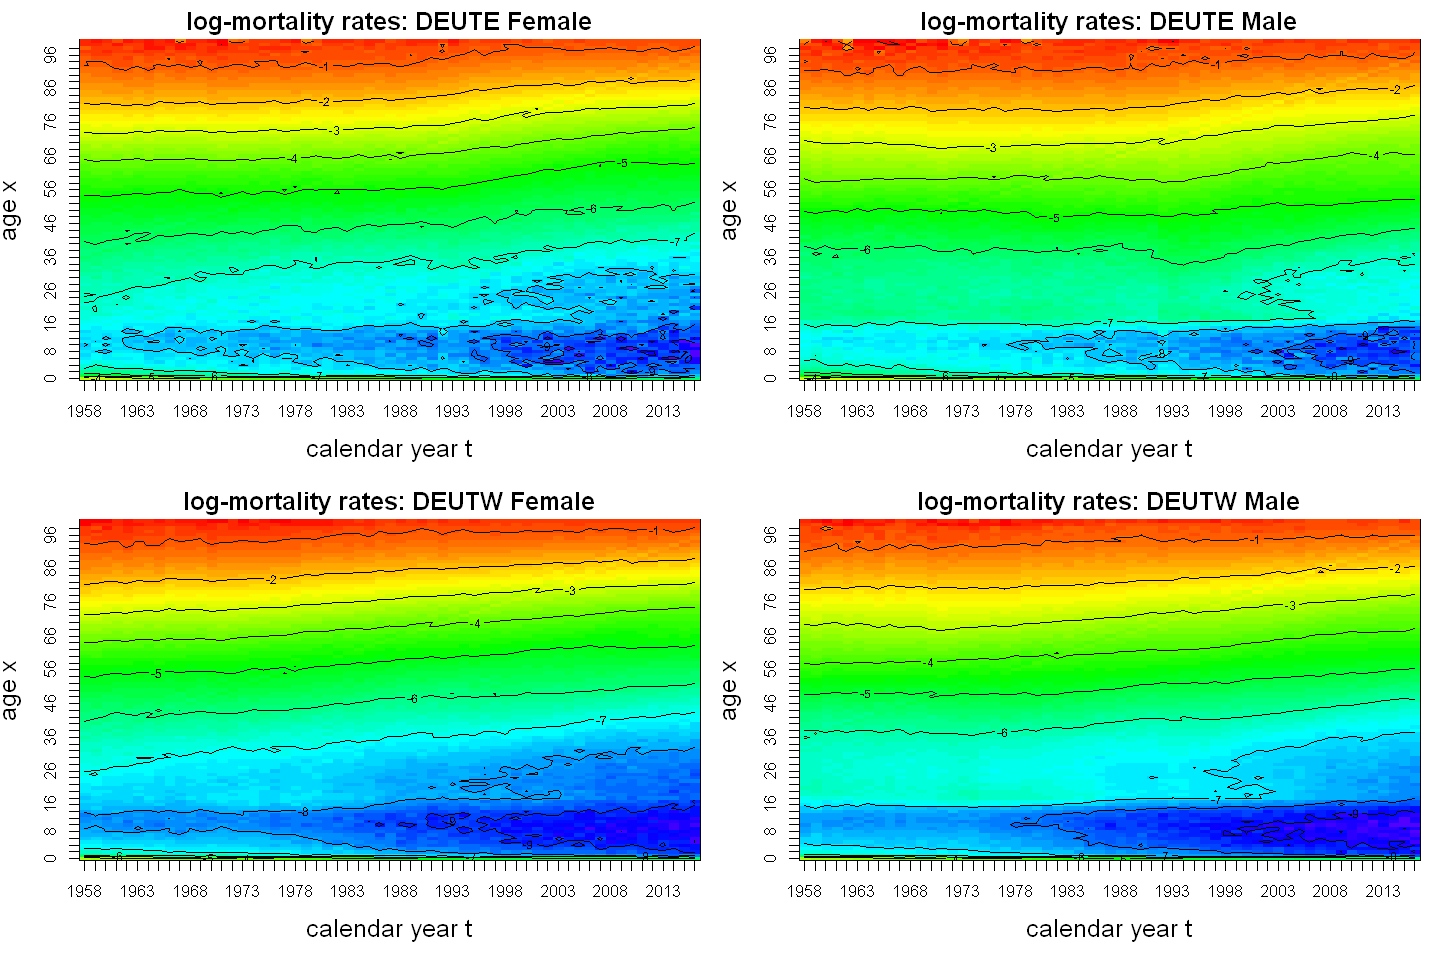

In [9]:
options(repr.plot.width = 12, repr.plot.height = 8)
par(mfrow=c(2,2),mar=c(5, 4, 2, 1)) 
myHeatmap("DEUTE","Female") # Germany, East
myHeatmap("DEUTE","Male")
myHeatmap("DEUTW","Female") # Germany, West
myHeatmap("DEUTW","Male")

Drawing on the insights regarding the statistical associations between log mortality rates and the features (Gender, Age, Country and Year) as shown above, we use the following variables as input features for the neural network:

* Gender, Age and Country are modelled as categorical variables,
* Year is modelled as a numerical feature, capturing the time trend of mortality development over time.

The log mortality rates, ranging roughly between -10 and 0, are used as the output feature. 


# 3. Data Processing <a name="2_data_processing"></a>

In this chapter, we perform the necessary data preprocessing as well as  transformation regarding the input features in order to make the input suitable to feeding into neural networks.

The categorical features such as Gender, Country and Age and the numerical feature Year are used as the input features for the neural networks. Log mortality rates are used as the output feature. 

The categorical variables must be converted into numerical variables first in order to be able to be fed into the embedding layers of the neural net used for mortality modelling. In this regard, Richman and Wüthrich (2018) used the approach of embedding layer instead of one-hot-Encoding approach. Under embedding layer approach, each level of categorical variable is converted into integers or index; after this tranformation, categorical variables in the form of index or integer are fed into the neural network. In comparison to one-hot-Encoding approach, embedding layer is a more efficient way of feature representation for categorical variables, since it can represent a multi-dimensional categorical variable with significantly fewer dimensions. For example, the categorical variable "Country" has 9 different levels (countries); under one-hot-encoding, one has to represent each country with a vector of 9 dimensions consisting of 8 values of 0 and one value of 1. Under embedding layer approach, each country can be represented with a vector of dimension 5 consisting of 5 continuous values. 

In chapter 5.2.3, we extract the 5-dimensional vectors for the three embedding layers learned in one neural network and show how embedding layers look like.


In [10]:
### This is the unprocessed test dataset, which will be merged with the predicted mortality rates from neural network.

pred_raw <- dplyr::filter(data,Year%in%2006:2016)


In [11]:
### inspect the data types of the dataset
sapply(data, class)  

Country          year        Gender           Age log_mortality 
     "factor"     "integer"      "factor"     "integer"     "numeric" 
    mortality 
    "numeric"

In [12]:
## the following lines of code convert the three categorical variables into numerical variables.

cat_features <- c("Country","Gender","Age")
cat_variable <- c("Country_cat","Gender_cat","Age_cat")

### change the data type of the three categorical variables into factor
data[cat_variable] <- lapply(data[cat_features], factor)

### convert the different levels of categorical variables into integer or index starting from 1. This is necessary for the embedding layers mentioned below for neural nets. 
data[cat_features] <- lapply(data[cat_variable], as.integer)

### convert the integer or index starting from 0

data[cat_features]<-data[cat_features]-1





In [13]:
# Convert the datatype of the feature Year into numeric.
data$Year <- as.numeric(as.character(data$Year))

In [14]:
head(data)

Country,year,Gender,Age,log_mortality,mortality,Country_cat,Gender_cat,Age_cat
0,1950,0,0,-3.601125,0.027293,CHE,Female,0
0,1950,0,1,-5.793926,0.003046,CHE,Female,1
0,1950,0,2,-6.392539,0.001674,CHE,Female,2
0,1950,0,3,-6.697494,0.001234,CHE,Female,3
0,1950,0,4,-6.900780,0.001007,CHE,Female,4
0,1950,0,5,-7.476916,0.000566,CHE,Female,5


Reorder the columns of the dataframe "data"

In [15]:
 data<-data %>% select(Country_cat,Gender_cat,Age_cat,Country,Year,Gender,Age, log_mortality, mortality)



In [16]:
sample_n(data,15)

Country_cat,Gender_cat,Age_cat,Country,year,Gender,Age,log_mortality,mortality
FRATNP,Male,50,4,1980,1,50,-4.746503,0.008682
USA,Female,74,8,1978,0,74,-3.421053,0.032678
ESP,Male,36,3,1992,1,36,-6.187479,0.002055
POL,Female,93,7,1989,0,93,-1.186546,0.305274
JPN,Female,97,6,2004,0,97,-1.412601,0.243509
DNK,Male,24,2,1991,1,24,-7.112322,0.000815
ITA,Female,78,5,1986,0,78,-2.962375,0.051696
ITA,Female,42,5,2014,0,42,-7.411936,0.000604
FRATNP,Male,93,4,1994,1,93,-1.231536,0.291844
JPN,Male,71,6,1979,1,71,-3.237753,0.039252


Show the mapping between the categorical variable (Country) and the index.

In [17]:
country_mapping=unique(data[,c('Country_cat','Country')])
row.names(country_mapping) <- NULL
country_mapping


Country_cat,Country
CHE,0
DEUT,1
DNK,2
ESP,3
FRATNP,4
ITA,5
JPN,6
POL,7
USA,8


Show the mapping between the categorical variable (Age) and the index.

In [18]:
age_mapping=unique(data[,c('Age_cat','Age')])
row.names(age_mapping) <- NULL
age_mapping

Age_cat,Age
0,0
1,1
2,2
3,3
4,4
5,5
6,6
7,7
8,8
9,9


Show the mapping between the categorical variable (Gender) and the index.

In [19]:
gender_mapping=unique(data[,c('Gender_cat','Gender')])
row.names(gender_mapping) <- NULL
gender_mapping

Gender_cat,Gender
Female,0
Male,1


In [20]:
#### View 10 random observations of the preprocessed dataset
sample_n(data,10)

Country_cat,Gender_cat,Age_cat,Country,year,Gender,Age,log_mortality,mortality
FRATNP,Male,15,4,1993,1,15,-7.684284,0.000460
FRATNP,Male,84,4,1964,1,84,-1.753014,0.173251
CHE,Female,45,0,1963,0,45,-6.067914,0.002316
USA,Female,27,8,1995,0,27,-7.376160,0.000626
CHE,Male,43,0,1965,1,43,-5.732182,0.003240
ITA,Male,5,5,1993,1,5,-8.426439,0.000219
CHE,Female,2,0,1960,0,2,-6.493000,0.001514
FRATNP,Female,5,4,1998,0,5,-8.825078,0.000147
CHE,Male,83,0,2012,1,83,-2.585651,0.075347
USA,Female,5,8,1989,0,5,-8.286081,0.000252


# 4. Prepare Training and Test Data for the Neural Network <a name="3_prepareNN"></a>

The training data used to train the neural network are mortality rates for ages from 0 to 100 for both females and males from 1956 to 2005. Here we do not perform a two-step procedure from Richman and Wüthrich (2018), but rather separate training and test data from the beginning. Our test data contain the mortality rates for all ages, genders and countries from 2006 to 2016.

The reason we omit the first step lies in the fact that we perform a hyperparameter search. This implies that we do not need a preliminary step which should indicate which neural networks infrastructures will presumable perform best in the final training.

It is also worth pointing out that the loss metrics used in Richman and Wüthrich (2018) cannot be directly compared with ours. We look at only 9 countries (or 10 regions) and our data preprocessing also differ from our guiding article Richman and Wüthrich (2018). 

10% of the training data are sampled out as validation dataset, which are used to select the best-performing set of hyperparameters for the neural network by monitoring the validation loss (mean squared error). To make sure the validation set is representative of the training data, we construct our validation set by performing stratified sampling on the training data by the two variables (year and age), selecting 10% of observations on each group (Year_Age). 

The final comparisons are performed on the test data which are unseen during the training.

##  4.1 Preparation of the Training Dataset

In [21]:
## Select the data from training data set (1956 to 2005).

training <-dplyr::filter(data,Year%in%1956:2005)

#training <- training[sample(nrow(training)),]



#### Set up the validation Set 

In [22]:
col_vector <- c("Year","Age","Country","Gender","log_mortality")

Training<- training %>% select(one_of(col_vector))

In [23]:
val<-splitstackshape::stratified(Training, c('Year','Age'), 0.1)

In [24]:
head(val,15)

year,Age,Country,Gender,log_mortality
1956,0,8,1,-3.450367
1956,0,0,0,-3.778367
1956,1,0,1,-5.917099
1956,1,8,1,-6.245067
1956,2,5,1,-6.010851
1956,2,8,0,-6.945457
1956,3,2,0,-7.218365
1956,3,0,0,-6.972827
1956,4,2,1,-7.706263
1956,4,8,1,-7.214280


In [25]:

#### prepare the input features for the validation set

X_validation <- val[,c("Year","Age","Country","Gender")]

X_val <- list(as.matrix(X_validation$Year),as.matrix(X_validation$Age),as.matrix(X_validation$Country),as.matrix(X_validation$Gender))


#### Prepare the output feature for the validation set

y_validation <- val[, "log_mortality"]

y_val <- as.matrix(y_validation)

#### Set up the Traning Set

In [26]:
train<-setdiff(Training,val)

In [27]:
#### Prepare the input features to be fed into the neural nets and convert them into arrays

X_training <- train[,c("Year","Age","Country","Gender")]

X_dev <- list(as.matrix(X_training$Year),as.matrix(X_training$Age),as.matrix(X_training$Country),as.matrix(X_training$Gender))


#### Prepare the output feature to be fed into the neural nets and convert it into array

y_training <- train[, "log_mortality"]

y_dev <- as.matrix(y_training)

##  4.2 Preparation of the Test Dataset

In [28]:
#### Select the test set (2006 to 2016)

test <- dplyr::filter(data,Year%in%2006:2016)


#### Prepare the input features for the test dataset and convert them into arrays

X_test <- test[,c("Year","Age","Country","Gender")]

X_test_1st <- list(as.matrix(X_test$Year),as.matrix(X_test$Age),as.matrix(X_test$Country),as.matrix(X_test$Gender))


#### Prepare the output feature for the test dataset and convert them into arrays
y_test <- test[, "log_mortality"]
y_test_1st <- as.matrix(y_test)


# 5. Set Up the Neural Network Architechture <a name="4_architecture"></a>



## 5.1.  Basic Architechture of Neural Network 

The basic code for the architecture of the neural network is from Richman and Wüthrich (2018), as shown in the appendix in listing 2. We call their model "model_rw" in the following.



In [3]:
Year <- layer_input(shape=c(1),dtype="float32",name="Year")
Age <- layer_input(shape=c(1),dtype="int32",name="Age")
Country <- layer_input(shape=c(1),dtype="int32",name="Country")
Gender <- layer_input(shape=c(1),dtype="int32",name="Gender")


##### Set up the embedding layer of the neural nets


Age_embed <- Age %>% 
  layer_embedding(input_dim = 101,output_dim=5,input_length=1,name="Age_embed") %>% 
  keras::layer_flatten()

Gender_embed <- Gender %>% 
  layer_embedding(input_dim=2,output_dim=5,input_length = 1,name="Gender_embed") %>% 
  keras::layer_flatten()

Country_embed <- Country %>% 
  layer_embedding(input_dim=9,output_dim = 5,input_length = 1,name="Country_embed") %>% 
  keras::layer_flatten()


##### Merge all the feature vectors 

features <- layer_concatenate(list(Year,Age_embed,Gender_embed,Country_embed))

##### set up the hidden layers
middle <- features %>%     
      layer_dense(units=128,activation="tanh") %>% 
      layer_batch_normalization() %>% 
      layer_dropout(0.05) %>% 
    
      layer_dense(units=128,activation="tanh") %>% 
      layer_batch_normalization() %>% 
      layer_dropout(0.05) %>%  
   
      layer_dense(units=128,activation="tanh") %>% 
      layer_batch_normalization() %>% 
      layer_dropout(0.05) %>%    
  
      layer_dense(units=128,activation="tanh") %>% 
      layer_batch_normalization() %>% 
      layer_dropout(0.05)     
      
##### Set up the output layer

main_output <- layer_concatenate(list(features,middle)) %>% 
  layer_dense(units=128,activation="tanh") %>% 
  layer_batch_normalization() %>% 
  layer_dropout(0.05) %>% 
  layer_dense(units = 1, activation = 'sigmoid', name = 'main_output') 


#### Set up the model combining input layers and output layer

model_rw <- keras_model(inputs=c(Year,Age,Country,Gender),outputs=c(main_output))

In [4]:
summary(model_rw)

Model: "model_1"
________________________________________________________________________________
Layer (type)              Output Shape      Param #  Connected to               
Age (InputLayer)          [(None, 1)]       0                                   
________________________________________________________________________________
Gender (InputLayer)       [(None, 1)]       0                                   
________________________________________________________________________________
Country (InputLayer)      [(None, 1)]       0                                   
________________________________________________________________________________
Age_embed (Embedding)     (None, 1, 5)      505      Age[0][0]                  
________________________________________________________________________________
Gender_embed (Embedding)  (None, 1, 5)      10       Gender[0][0]               
________________________________________________________________________________
Country_emb

## 5.2. Hyperparameter Search Function

The point of departure for our training of neural networks is the article "A Neural Network Extension of the Lee-Carter Model to Multiple Populations", Richman and Wüthrich (2018). We introduce the hyperparameter serach, which is mentioned in their article as a potential extension of their approach. We have written the code for hyperparameter search functions, which will enable the users to search over a predefined hyperparameter space and find the best-performing configurations of hyperparameters. The hyperparameters searched over in this notebook are the following: (1) the number of layers; (2) dropout; (3) the number of neurons in each layer; (3) learning rate; (4) batchsize; (5) activation function. The number of hyperparameters can be further increased.


### 5.2.1 Specify the Architechture of the neural Network for hyperparameter search

The code in the following cell is intended to show the reader the code used for the hyperparameter search, which are saved in a R script ("nn_mortality.R") and will be used as an input for the hyperparameter search function in chapter 5.2.2. Alternatively, the reader can also directly save the code contained in the function writeLines() as a R script and save the script in the working directory. 



In [5]:
printer = file("nn_mortality.R","w")
 writeLines("FLAGS <- flags(
  flag_integer('layers', 3),
  flag_numeric('dropout', 0.05),
  flag_integer('neurons', 128),
  flag_numeric('lr', 0.01),
  flag_integer('patience', 35),
  flag_integer('pats', 20),
  flag_integer('batchsize', 1200),
  flag_string('activation', 'relu')   
)

build_model <- function() {
  
  Year <- layer_input(shape=c(1),dtype='float32',name='Year')
  Age <- layer_input(shape=c(1),dtype='int32',name='Age')
  Country <- layer_input(shape=c(1),dtype='int32',name='Country')
  Gender <- layer_input(shape=c(1),dtype='int32',name='Gender')
    
  ##### set up the embedding layer of the neural nets
  
  
  Age_embed <- Age %>% 
    layer_embedding(input_dim = 101,output_dim=5,input_length=1,name='Age_embed') %>% 
    keras::layer_flatten()
  
  Gender_embed <- Gender %>% 
    layer_embedding(input_dim=2,output_dim=5,input_length = 1,name='Gender_embed') %>% 
    keras::layer_flatten()
  
  
  Country_embed <- Country %>% 
    layer_embedding(input_dim=9,output_dim = 5,input_length = 1,name='Country_embed') %>% 
    keras::layer_flatten()
  
  ##### merge all the feature vectors 
  
  features <- layer_concatenate(list(Year,Age_embed,Gender_embed,Country_embed)) 

   middle<-features 

for (i in (1: FLAGS$layers)){  
      middle <- middle %>% 
      layer_dense(units=FLAGS$neurons,activation=FLAGS$activation) %>% 
      layer_batch_normalization() %>% 
      layer_dropout(FLAGS$dropout)      
  }  


  ##### set up the output layer
  
  main_output <- layer_concatenate(list(features,middle)) %>% 
     layer_dense(units=FLAGS$neurons,activation=FLAGS$activation) %>%
     layer_batch_normalization() %>% 
     layer_dropout(FLAGS$dropout)%>% 
    layer_dense(units=1,name='main_output')
  
  #### set up the model combining input layers and output layer
  
  model <- keras_model(inputs=c(Year,Age,Country,Gender),outputs=c(main_output))
  
  
  model %>% compile(
    optimizer_adam(lr = FLAGS$lr),
    loss='mse',
    metrics=c('mae')
  )
  model
}

model <- build_model()


##### the folowing two callback functions are used to control the training process by monitoring the validation loss

early_stop <- callback_early_stopping(monitor = 'val_loss', patience = FLAGS$patience)


lr_reducer <- callback_reduce_lr_on_plateau(monitor = 'val_loss', factor = 0.1,
                                            patience = FLAGS$pats, verbose = 0, mode = 'min',
                                            min_delta = 1e-04, cooldown = 0, min_lr = 0)


### Fit the neural network specified as above

history <- model %>% fit(
  x  = X_dev, 
  y  = y_dev,
  batch_size = FLAGS$batchsize, 
  epochs = 250,
  validation_data =list(X_val, y_val),
  verbose = 1,
  callbacks = list(early_stop,lr_reducer)
)


# plot(history)

score <- model %>% evaluate(X_test_1st, y_test_1st, verbose = 0)

save_model_hdf5(model, 'model.h5')

# cat('Test loss:', score$loss)

",con=printer,sep=" ")

 close(printer)


### 5.2.2 Specification of the Hyperparameter Search Space and Training of Neural Networks with the Sampled Hyperparameters

We specify a relatively small hyperparameter space to be searched over, these are the possible combinations of hyperparameters. The sample parameter in the tuning_run function is set to be 0.05, so that 5% of all possible combinations will be selected for the hyperparameter search. Obviously the hyperparameter space can be extended by specifying more possible values for each hyperparameter. Furthermore, the sample parameter in the function tuning_run can be set accordingly to a smaller or larger value (between 0 and 1) so that the number of the randomly selected combinations is not too large and does not take too much time to run through.

The values chosen for the patience parameters and activation function correspond to values leading to good results according to our experience. Our code allows for changing of these parameters (e.g. activation function to sigmoid or tanh) and we encourage the readers to do this. 

The seed can be set to be chosen randomly. For the sake of reproducibility, we have fixed its value.


In [33]:
set.seed(8)
par <- list( 
    layers = c(3,6,9),
    dropout = c(0.01,0.03,0.05,0.07),
    neurons = c(128,160,192,224,256),
    batchsize = c(400,800,1200),
    lr = c(0.05,0.1,0.15),
    patience = c(35,45),
    pats = c(20,30),
    activation = c("relu")  
 )

runs <- tuning_run('nn_mortality.R', runs_dir = 'D_tuning', sample = 0.05, flags = par)




2,160 total combinations of flags (sampled to 108 combinations)


Training run 1/108 (flags = list(3, 0.03, 192, 800, 0.1, 45, 30, "relu")) 
Using run directory D_tuning/2020-08-28T14-06-02Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-28T14-06-02Z

Training run 2/108 (flags = list(9, 0.07, 128, 800, 0.1, 35, 30, "relu")) 
Using run directory D_tuning/2020-08-28T14-19-27Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-28T14-19-27Z

Training run 3/108 (flags = list(3, 0.07, 160, 1200, 0.05, 45, 30, "relu")) 
Using run directory D_tuning/2020-08-28T14-36-37Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-28T14-36-37Z

Training run 4/108 (flags = list(9, 0.01, 256, 400, 0.05, 45, 20, "relu")) 
Using run directory D_tuning/2020-08-28T14-44-27Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-28T14-44-27Z

Training run 5/108 (flags = list(6, 0.05, 160, 800, 0.15, 45, 30, "relu")) 
Using run directory D_tuning/2020-08-28T15-14-56Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-28T15-14-56Z

Training run 6/108 (flags = list(3, 0.05, 256, 1200, 0.05, 35, 30, "relu")) 
Using run directory D_tuning/2020-08-28T15-31-33Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-28T15-31-33Z

Training run 7/108 (flags = list(9, 0.03, 160, 400, 0.1, 35, 30, "relu")) 
Using run directory D_tuning/2020-08-28T15-40-14Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-28T15-40-14Z

Training run 8/108 (flags = list(9, 0.05, 160, 400, 0.1, 35, 30, "relu")) 
Using run directory D_tuning/2020-08-28T16-09-55Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-28T16-09-55Z

Training run 9/108 (flags = list(6, 0.03, 160, 1200, 0.05, 45, 30, "relu")) 
Using run directory D_tuning/2020-08-28T16-45-59Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-28T16-45-59Z

Training run 10/108 (flags = list(9, 0.01, 192, 1200, 0.1, 45, 20, "relu")) 
Using run directory D_tuning/2020-08-28T16-57-17Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-28T16-57-17Z

Training run 11/108 (flags = list(6, 0.01, 192, 800, 0.05, 35, 20, "relu")) 
Using run directory D_tuning/2020-08-28T17-09-33Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-28T17-09-33Z

Training run 12/108 (flags = list(9, 0.07, 224, 400, 0.15, 45, 20, "relu")) 
Using run directory D_tuning/2020-08-28T17-22-41Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-28T17-22-41Z

Training run 13/108 (flags = list(6, 0.07, 256, 800, 0.05, 45, 30, "relu")) 
Using run directory D_tuning/2020-08-28T17-51-39Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-28T17-51-39Z

Training run 14/108 (flags = list(3, 0.03, 128, 1200, 0.1, 35, 30, "relu")) 
Using run directory D_tuning/2020-08-28T18-06-17Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-28T18-06-17Z

Training run 15/108 (flags = list(3, 0.01, 128, 400, 0.1, 45, 30, "relu")) 
Using run directory D_tuning/2020-08-28T18-15-09Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-28T18-15-09Z

Training run 16/108 (flags = list(6, 0.07, 128, 400, 0.1, 45, 30, "relu")) 
Using run directory D_tuning/2020-08-28T18-37-31Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-28T18-37-31Z

Training run 17/108 (flags = list(3, 0.05, 160, 1200, 0.1, 35, 20, "relu")) 
Using run directory D_tuning/2020-08-28T19-01-38Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-28T19-01-38Z

Training run 18/108 (flags = list(9, 0.03, 192, 800, 0.1, 35, 30, "relu")) 
Using run directory D_tuning/2020-08-28T19-08-20Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-28T19-08-20Z

Training run 19/108 (flags = list(6, 0.01, 224, 800, 0.05, 35, 30, "relu")) 
Using run directory D_tuning/2020-08-28T19-27-45Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-28T19-27-45Z

Training run 20/108 (flags = list(3, 0.05, 160, 400, 0.15, 45, 30, "relu")) 
Using run directory D_tuning/2020-08-28T19-42-40Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-28T19-42-40Z

Training run 21/108 (flags = list(6, 0.07, 128, 400, 0.1, 35, 20, "relu")) 
Using run directory D_tuning/2020-08-28T20-07-07Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-28T20-07-07Z

Training run 22/108 (flags = list(9, 0.03, 256, 1200, 0.05, 45, 20, "relu")) 
Using run directory D_tuning/2020-08-28T20-30-56Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-28T20-30-56Z

Training run 23/108 (flags = list(6, 0.03, 128, 800, 0.15, 45, 30, "relu")) 
Using run directory D_tuning/2020-08-28T20-44-43Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-28T20-44-43Z

Training run 24/108 (flags = list(3, 0.01, 224, 400, 0.05, 45, 30, "relu")) 
Using run directory D_tuning/2020-08-28T21-00-51Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-28T21-00-51Z

Training run 25/108 (flags = list(6, 0.01, 128, 800, 0.05, 35, 20, "relu")) 
Using run directory D_tuning/2020-08-28T21-24-42Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-28T21-24-42Z

Training run 26/108 (flags = list(3, 0.01, 128, 1200, 0.15, 45, 30, "relu")) 
Using run directory D_tuning/2020-08-28T21-37-52Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-28T21-37-52Z

Training run 27/108 (flags = list(6, 0.01, 256, 1200, 0.1, 45, 20, "relu")) 
Using run directory D_tuning/2020-08-28T21-46-38Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-28T21-46-38Z

Training run 28/108 (flags = list(6, 0.07, 192, 400, 0.05, 45, 20, "relu")) 
Using run directory D_tuning/2020-08-28T21-58-14Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-28T21-58-14Z

Training run 29/108 (flags = list(6, 0.01, 256, 1200, 0.1, 35, 30, "relu")) 
Using run directory D_tuning/2020-08-28T22-19-11Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-28T22-19-11Z

Training run 30/108 (flags = list(9, 0.05, 256, 400, 0.05, 45, 20, "relu")) 
Using run directory D_tuning/2020-08-28T22-30-59Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-28T22-30-59Z

Training run 31/108 (flags = list(3, 0.03, 128, 1200, 0.1, 35, 20, "relu")) 
Using run directory D_tuning/2020-08-28T22-56-02Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-28T22-56-02Z

Training run 32/108 (flags = list(3, 0.03, 160, 400, 0.1, 35, 30, "relu")) 
Using run directory D_tuning/2020-08-28T23-02-32Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-28T23-02-32Z

Training run 33/108 (flags = list(6, 0.03, 224, 400, 0.15, 45, 30, "relu")) 
Using run directory D_tuning/2020-08-28T23-25-52Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-28T23-25-52Z

Training run 34/108 (flags = list(3, 0.03, 224, 1200, 0.1, 35, 30, "relu")) 
Using run directory D_tuning/2020-08-28T23-46-41Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-28T23-46-41Z

Training run 35/108 (flags = list(9, 0.05, 224, 400, 0.1, 35, 30, "relu")) 
Using run directory D_tuning/2020-08-28T23-54-10Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-28T23-54-10Z

Training run 36/108 (flags = list(6, 0.05, 224, 800, 0.15, 35, 30, "relu")) 
Using run directory D_tuning/2020-08-29T00-34-48Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-29T00-34-48Z

Training run 37/108 (flags = list(6, 0.01, 128, 1200, 0.15, 45, 30, "relu")) 
Using run directory D_tuning/2020-08-29T00-46-19Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-29T00-46-19Z

Training run 38/108 (flags = list(6, 0.07, 192, 800, 0.15, 35, 20, "relu")) 
Using run directory D_tuning/2020-08-29T00-57-58Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-29T00-57-58Z

Training run 39/108 (flags = list(6, 0.03, 160, 1200, 0.1, 35, 30, "relu")) 
Using run directory D_tuning/2020-08-29T01-12-51Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-29T01-12-51Z

Training run 40/108 (flags = list(3, 0.03, 256, 800, 0.05, 35, 20, "relu")) 
Using run directory D_tuning/2020-08-29T01-24-18Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-29T01-24-18Z

Training run 41/108 (flags = list(9, 0.01, 192, 400, 0.05, 35, 30, "relu")) 
Using run directory D_tuning/2020-08-29T01-35-47Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-29T01-35-47Z

Training run 42/108 (flags = list(3, 0.01, 160, 400, 0.1, 35, 30, "relu")) 
Using run directory D_tuning/2020-08-29T02-07-21Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-29T02-07-21Z

Training run 43/108 (flags = list(6, 0.05, 160, 1200, 0.05, 35, 20, "relu")) 
Using run directory D_tuning/2020-08-29T02-31-20Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-29T02-31-20Z

Training run 44/108 (flags = list(9, 0.01, 224, 400, 0.1, 45, 30, "relu")) 
Using run directory D_tuning/2020-08-29T02-40-41Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-29T02-40-41Z

Training run 45/108 (flags = list(9, 0.03, 192, 800, 0.1, 45, 30, "relu")) 
Using run directory D_tuning/2020-08-29T03-05-00Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-29T03-05-00Z

Training run 46/108 (flags = list(9, 0.01, 224, 1200, 0.1, 35, 30, "relu")) 
Using run directory D_tuning/2020-08-29T03-22-31Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-29T03-22-31Z

Training run 47/108 (flags = list(3, 0.01, 128, 400, 0.15, 35, 20, "relu")) 
Using run directory D_tuning/2020-08-29T03-34-53Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-29T03-34-53Z

Training run 48/108 (flags = list(3, 0.03, 192, 400, 0.05, 45, 30, "relu")) 
Using run directory D_tuning/2020-08-29T03-53-37Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-29T03-53-37Z

Training run 49/108 (flags = list(6, 0.03, 160, 400, 0.1, 45, 30, "relu")) 
Using run directory D_tuning/2020-08-29T04-17-27Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-29T04-17-27Z

Training run 50/108 (flags = list(6, 0.01, 256, 400, 0.1, 35, 20, "relu")) 
Using run directory D_tuning/2020-08-29T04-49-04Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-29T04-49-04Z

Training run 51/108 (flags = list(9, 0.07, 224, 400, 0.15, 35, 30, "relu")) 
Using run directory D_tuning/2020-08-29T05-12-39Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-29T05-12-39Z

Training run 52/108 (flags = list(9, 0.05, 224, 400, 0.15, 45, 30, "relu")) 
Using run directory D_tuning/2020-08-29T05-48-16Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-29T05-48-16Z

Training run 53/108 (flags = list(9, 0.07, 256, 800, 0.15, 45, 30, "relu")) 
Using run directory D_tuning/2020-08-29T06-25-06Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-29T06-25-06Z

Training run 54/108 (flags = list(6, 0.03, 128, 400, 0.1, 45, 20, "relu")) 
Using run directory D_tuning/2020-08-29T06-44-23Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-29T06-44-23Z

Training run 55/108 (flags = list(9, 0.05, 256, 800, 0.1, 45, 20, "relu")) 
Using run directory D_tuning/2020-08-29T07-10-51Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-29T07-10-51Z

Training run 56/108 (flags = list(9, 0.07, 224, 800, 0.05, 35, 20, "relu")) 
Using run directory D_tuning/2020-08-29T07-29-16Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-29T07-29-16Z

Training run 57/108 (flags = list(3, 0.03, 192, 1200, 0.15, 35, 30, "relu")) 
Using run directory D_tuning/2020-08-29T07-42-25Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-29T07-42-25Z

Training run 58/108 (flags = list(6, 0.01, 224, 1200, 0.05, 45, 30, "relu")) 
Using run directory D_tuning/2020-08-29T07-50-37Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-29T07-50-37Z

Training run 59/108 (flags = list(6, 0.03, 256, 1200, 0.1, 35, 30, "relu")) 
Using run directory D_tuning/2020-08-29T08-02-05Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-29T08-02-05Z

Training run 60/108 (flags = list(9, 0.03, 256, 400, 0.15, 45, 30, "relu")) 
Using run directory D_tuning/2020-08-29T08-12-56Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-29T08-12-56Z

Training run 61/108 (flags = list(9, 0.05, 256, 400, 0.05, 35, 20, "relu")) 
Using run directory D_tuning/2020-08-29T08-49-51Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-29T08-49-51Z

Training run 62/108 (flags = list(6, 0.07, 192, 1200, 0.15, 45, 30, "relu")) 
Using run directory D_tuning/2020-08-29T09-19-34Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-29T09-19-34Z

Training run 63/108 (flags = list(9, 0.07, 128, 1200, 0.15, 35, 30, "relu")) 
Using run directory D_tuning/2020-08-29T09-31-07Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-29T09-31-07Z

Training run 64/108 (flags = list(3, 0.01, 256, 800, 0.1, 35, 20, "relu")) 
Using run directory D_tuning/2020-08-29T09-42-57Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-29T09-42-57Z

Training run 65/108 (flags = list(9, 0.07, 160, 800, 0.15, 35, 30, "relu")) 
Using run directory D_tuning/2020-08-29T09-54-19Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-29T09-54-19Z

Training run 66/108 (flags = list(9, 0.03, 256, 1200, 0.15, 35, 30, "relu")) 
Using run directory D_tuning/2020-08-29T10-11-50Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-29T10-11-50Z

Training run 67/108 (flags = list(3, 0.03, 160, 800, 0.1, 35, 20, "relu")) 
Using run directory D_tuning/2020-08-29T10-25-12Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-29T10-25-12Z

Training run 68/108 (flags = list(9, 0.01, 128, 1200, 0.15, 35, 30, "relu")) 
Using run directory D_tuning/2020-08-29T10-37-48Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-29T10-37-48Z

Training run 69/108 (flags = list(3, 0.01, 160, 400, 0.05, 45, 30, "relu")) 
Using run directory D_tuning/2020-08-29T10-50-22Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-29T10-50-22Z

Training run 70/108 (flags = list(6, 0.07, 160, 400, 0.05, 45, 20, "relu")) 
Using run directory D_tuning/2020-08-29T11-11-22Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-29T11-11-22Z

Training run 71/108 (flags = list(6, 0.03, 256, 400, 0.15, 45, 30, "relu")) 
Using run directory D_tuning/2020-08-29T11-31-12Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-29T11-31-12Z

Training run 72/108 (flags = list(9, 0.05, 192, 1200, 0.15, 45, 30, "relu")) 
Using run directory D_tuning/2020-08-29T11-48-21Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-29T11-48-21Z

Training run 73/108 (flags = list(6, 0.07, 160, 400, 0.1, 35, 30, "relu")) 
Using run directory D_tuning/2020-08-29T12-00-48Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-29T12-00-48Z

Training run 74/108 (flags = list(6, 0.03, 160, 1200, 0.15, 45, 20, "relu")) 
Using run directory D_tuning/2020-08-29T12-22-45Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-29T12-22-45Z

Training run 75/108 (flags = list(3, 0.03, 224, 1200, 0.05, 45, 30, "relu")) 
Using run directory D_tuning/2020-08-29T12-32-47Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-29T12-32-47Z

Training run 76/108 (flags = list(3, 0.01, 128, 800, 0.1, 45, 20, "relu")) 
Using run directory D_tuning/2020-08-29T12-41-43Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-29T12-41-43Z

Training run 77/108 (flags = list(9, 0.05, 128, 400, 0.15, 45, 20, "relu")) 
Using run directory D_tuning/2020-08-29T12-52-35Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-29T12-52-35Z

Training run 78/108 (flags = list(6, 0.05, 256, 800, 0.1, 45, 30, "relu")) 
Using run directory D_tuning/2020-08-29T13-20-52Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-29T13-20-52Z

Training run 79/108 (flags = list(9, 0.07, 160, 400, 0.05, 45, 20, "relu")) 
Using run directory D_tuning/2020-08-29T13-36-40Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-29T13-36-40Z

Training run 80/108 (flags = list(6, 0.05, 192, 800, 0.1, 35, 20, "relu")) 
Using run directory D_tuning/2020-08-29T14-03-56Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-29T14-03-56Z

Training run 81/108 (flags = list(3, 0.03, 128, 1200, 0.05, 35, 20, "relu")) 
Using run directory D_tuning/2020-08-29T14-15-31Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-29T14-15-31Z

Training run 82/108 (flags = list(9, 0.07, 128, 1200, 0.05, 45, 20, "relu")) 
Using run directory D_tuning/2020-08-29T14-23-06Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-29T14-23-06Z

Training run 83/108 (flags = list(9, 0.03, 256, 400, 0.05, 45, 20, "relu")) 
Using run directory D_tuning/2020-08-29T14-34-05Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-29T14-34-05Z

Training run 84/108 (flags = list(9, 0.05, 256, 1200, 0.05, 45, 30, "relu")) 
Using run directory D_tuning/2020-08-29T15-11-10Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-29T15-11-10Z

Training run 85/108 (flags = list(3, 0.07, 128, 800, 0.1, 45, 20, "relu")) 
Using run directory D_tuning/2020-08-29T15-24-00Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-29T15-24-00Z

Training run 86/108 (flags = list(3, 0.03, 128, 1200, 0.1, 45, 20, "relu")) 
Using run directory D_tuning/2020-08-29T15-35-56Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-29T15-35-56Z

Training run 87/108 (flags = list(6, 0.01, 224, 1200, 0.15, 35, 30, "relu")) 
Using run directory D_tuning/2020-08-29T15-43-01Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-29T15-43-01Z

Training run 88/108 (flags = list(9, 0.01, 128, 400, 0.15, 45, 30, "relu")) 
Using run directory D_tuning/2020-08-29T15-54-31Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-29T15-54-31Z

Training run 89/108 (flags = list(3, 0.01, 192, 800, 0.05, 35, 20, "relu")) 
Using run directory D_tuning/2020-08-29T16-29-11Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-29T16-29-11Z

Training run 90/108 (flags = list(9, 0.03, 256, 800, 0.1, 45, 30, "relu")) 
Using run directory D_tuning/2020-08-29T16-39-05Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-29T16-39-05Z

Training run 91/108 (flags = list(3, 0.01, 192, 400, 0.1, 35, 30, "relu")) 
Using run directory D_tuning/2020-08-29T16-58-37Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-29T16-58-37Z

Training run 92/108 (flags = list(3, 0.07, 192, 800, 0.1, 35, 20, "relu")) 
Using run directory D_tuning/2020-08-29T17-15-44Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-29T17-15-44Z

Training run 93/108 (flags = list(3, 0.01, 128, 1200, 0.05, 35, 30, "relu")) 
Using run directory D_tuning/2020-08-29T17-24-43Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-29T17-24-43Z

Training run 94/108 (flags = list(3, 0.07, 160, 400, 0.15, 35, 30, "relu")) 
Using run directory D_tuning/2020-08-29T17-33-40Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-29T17-33-40Z

Training run 95/108 (flags = list(3, 0.07, 128, 800, 0.05, 45, 30, "relu")) 
Using run directory D_tuning/2020-08-29T17-51-51Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-29T17-51-51Z

Training run 96/108 (flags = list(3, 0.07, 224, 800, 0.1, 45, 30, "relu")) 
Using run directory D_tuning/2020-08-29T18-01-41Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-29T18-01-41Z

Training run 97/108 (flags = list(6, 0.05, 224, 400, 0.15, 45, 30, "relu")) 
Using run directory D_tuning/2020-08-29T18-14-24Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-29T18-14-24Z

Training run 98/108 (flags = list(6, 0.03, 192, 800, 0.1, 35, 20, "relu")) 
Using run directory D_tuning/2020-08-29T18-38-08Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-29T18-38-08Z

Training run 99/108 (flags = list(9, 0.03, 128, 1200, 0.1, 45, 20, "relu")) 
Using run directory D_tuning/2020-08-29T18-50-17Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-29T18-50-17Z

Training run 100/108 (flags = list(9, 0.03, 128, 800, 0.1, 45, 20, "relu")) 
Using run directory D_tuning/2020-08-29T19-02-33Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-29T19-02-33Z

Training run 101/108 (flags = list(6, 0.05, 160, 800, 0.1, 45, 30, "relu")) 
Using run directory D_tuning/2020-08-29T19-20-11Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-29T19-20-11Z

Training run 102/108 (flags = list(9, 0.03, 160, 1200, 0.1, 35, 20, "relu")) 
Using run directory D_tuning/2020-08-29T19-34-05Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-29T19-34-05Z

Training run 103/108 (flags = list(6, 0.01, 160, 400, 0.15, 45, 20, "relu")) 
Using run directory D_tuning/2020-08-29T19-43-24Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-29T19-43-24Z

Training run 104/108 (flags = list(9, 0.01, 192, 800, 0.05, 45, 30, "relu")) 
Using run directory D_tuning/2020-08-29T20-15-07Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-29T20-15-07Z

Training run 105/108 (flags = list(3, 0.03, 256, 400, 0.05, 35, 20, "relu")) 
Using run directory D_tuning/2020-08-29T20-34-02Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-29T20-34-02Z

Training run 106/108 (flags = list(3, 0.01, 128, 1200, 0.1, 35, 20, "relu")) 
Using run directory D_tuning/2020-08-29T20-53-43Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-29T20-53-43Z

Training run 107/108 (flags = list(6, 0.07, 192, 800, 0.1, 35, 20, "relu")) 
Using run directory D_tuning/2020-08-29T21-02-38Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-29T21-02-38Z

Training run 108/108 (flags = list(9, 0.05, 192, 1200, 0.15, 35, 30, "relu")) 
Using run directory D_tuning/2020-08-29T21-13-52Z



> FLAGS <- flags(flag_integer("layers", 4), flag_numeric("dropout", 
+     0.05), flag_integer("neurons", 128), flag_numeric("lr", 0.01), 
+     flag_ .... [TRUNCATED] 

> build_model <- function() {
+     Year <- layer_input(shape = c(1), dtype = "float32", name = "Year")
+     Age <- layer_input(shape = c(1), dtype = .... [TRUNCATED] 

> model <- build_model()

> early_stop <- callback_early_stopping(monitor = "val_loss", 
+     patience = FLAGS$patience)

> lr_reducer <- callback_reduce_lr_on_plateau(monitor = "val_loss", 
+     factor = 0.1, patience = FLAGS$pats, verbose = 0, mode = "min", 
+     min_ .... [TRUNCATED] 

> history <- model %>% fit(x = X_dev, y = y_dev, batch_size = FLAGS$batchsize, 
+     epochs = 250, validation_data = list(X_val, y_val), verbose = 1, .... [TRUNCATED] 

> score <- model %>% evaluate(X_test_1st, y_test_1st, 
+     verbose = 0)

> save_model_hdf5(model, "model.h5")



Run completed: D_tuning/2020-08-29T21-13-52Z



In [32]:

#### After the training we rank the performance of all hyperparameter search runs by validation loss in ascending order.

results <- ls_runs(order = metric_val_loss, decreasing= F, runs_dir = 'D_tuning')

results <- select(results,-c(output))

In [33]:
### Export the results of hyperparameter search to an excel table

results
writexl::write_xlsx(results, "results.xlsx")

,run_dir,metric_val_loss,eval_loss,eval_mean_absolute_error,metric_loss,metric_mean_absolute_error,metric_val_mean_absolute_error,flag_layers,flag_dropout,flag_neurons,...,loss_function,optimizer,learning_rate,script,start,end,completed,source_code,context,type
19,D_tuning/2020-08-29T16-39-05Z,0.0108,0.0316,1.100000e-01,0.0284,0.1226,0.0592,9,0.03,256,...,mse,<tensorflow.python.keras.optimizers.Adam>,0.10,nn_mortality.R,2020-08-29 16:39:13,2020-08-29 16:58:37,TRUE,D_tuning/2020-08-29T16-39-05Z/tfruns.d/source.tar.gz,local,training
5,D_tuning/2020-08-29T20-15-07Z,0.0109,0.0326,1.106000e-01,0.0228,0.1100,0.0588,9,0.01,192,...,mse,<tensorflow.python.keras.optimizers.Adam>,0.05,nn_mortality.R,2020-08-29 20:15:15,2020-08-29 20:34:02,TRUE,D_tuning/2020-08-29T20-15-07Z/tfruns.d/source.tar.gz,local,training
60,D_tuning/2020-08-29T04-17-27Z,0.0109,0.0313,1.083000e-01,0.0397,0.1484,0.0596,6,0.03,160,...,mse,<tensorflow.python.keras.optimizers.Adam>,0.10,nn_mortality.R,2020-08-29 04:17:35,2020-08-29 04:49:04,TRUE,D_tuning/2020-08-29T04-17-27Z/tfruns.d/source.tar.gz,local,training
84,D_tuning/2020-08-28T21-24-42Z,0.0109,0.0326,1.131000e-01,0.0237,0.1106,0.0596,6,0.01,128,...,mse,<tensorflow.python.keras.optimizers.Adam>,0.05,nn_mortality.R,2020-08-28 21:24:50,2020-08-28 21:37:52,TRUE,D_tuning/2020-08-28T21-24-42Z/tfruns.d/source.tar.gz,local,training
90,D_tuning/2020-08-28T19-27-45Z,0.0109,0.0318,1.063000e-01,0.0240,0.1122,0.0590,6,0.01,224,...,mse,<tensorflow.python.keras.optimizers.Adam>,0.05,nn_mortality.R,2020-08-28 19:27:53,2020-08-28 19:42:40,TRUE,D_tuning/2020-08-28T19-27-45Z/tfruns.d/source.tar.gz,local,training
91,D_tuning/2020-08-28T19-08-20Z,0.0109,0.0308,1.052000e-01,0.0304,0.1269,0.0597,9,0.03,192,...,mse,<tensorflow.python.keras.optimizers.Adam>,0.10,nn_mortality.R,2020-08-28 19:08:28,2020-08-28 19:27:45,TRUE,D_tuning/2020-08-28T19-08-20Z/tfruns.d/source.tar.gz,local,training
105,D_tuning/2020-08-28T14-44-27Z,0.0109,0.0333,1.134000e-01,0.0338,0.1389,0.0593,9,0.01,256,...,mse,<tensorflow.python.keras.optimizers.Adam>,0.05,nn_mortality.R,2020-08-28 14:44:35,2020-08-28 15:14:56,TRUE,D_tuning/2020-08-28T14-44-27Z/tfruns.d/source.tar.gz,local,training
26,D_tuning/2020-08-29T14-34-05Z,0.0110,0.0318,1.084000e-01,0.0339,0.1382,0.0599,9,0.03,256,...,mse,<tensorflow.python.keras.optimizers.Adam>,0.05,nn_mortality.R,2020-08-29 14:34:13,2020-08-29 15:11:10,TRUE,D_tuning/2020-08-29T14-34-05Z/tfruns.d/source.tar.gz,local,training
41,D_tuning/2020-08-29T10-37-48Z,0.0110,0.0315,1.109000e-01,0.0219,0.1046,0.0602,9,0.01,128,...,mse,<tensorflow.python.keras.optimizers.Adam>,0.15,nn_mortality.R,2020-08-29 10:37:56,2020-08-29 10:50:22,TRUE,D_tuning/2020-08-29T10-37-48Z/tfruns.d/source.tar.gz,local,training
42,D_tuning/2020-08-29T10-25-12Z,0.0110,0.0334,1.138000e-01,0.0282,0.1213,0.0608,3,0.03,160,...,mse,<tensorflow.python.keras.optimizers.Adam>,0.10,nn_mortality.R,2020-08-29 10:25:20,2020-08-29 10:37:48,TRUE,D_tuning/2020-08-29T10-25-12Z/tfruns.d/source.tar.gz,local,training


In [34]:
## For each run of the hyperparameter search, the results (weights and graphs) are saved in folder "D_tuning".

inputdir <- file.path(getwd(), "D_tuning")

## Display the folder names for the hyperparameter search runs.

list.files(inputdir)

[1] "2020-08-28T14-06-02Z" "2020-08-28T14-19-27Z" "2020-08-28T14-36-37Z"
  [4] "2020-08-28T14-44-27Z" "2020-08-28T15-14-56Z" "2020-08-28T15-31-33Z"
  [7] "2020-08-28T15-40-14Z" "2020-08-28T16-09-55Z" "2020-08-28T16-45-59Z"
 [10] "2020-08-28T16-57-17Z" "2020-08-28T17-09-33Z" "2020-08-28T17-22-41Z"
 [13] "2020-08-28T17-51-39Z" "2020-08-28T18-06-17Z" "2020-08-28T18-15-09Z"
 [16] "2020-08-28T18-37-31Z" "2020-08-28T19-01-38Z" "2020-08-28T19-08-20Z"
 [19] "2020-08-28T19-27-45Z" "2020-08-28T19-42-40Z" "2020-08-28T20-07-07Z"
 [22] "2020-08-28T20-30-56Z" "2020-08-28T20-44-43Z" "2020-08-28T21-00-51Z"
 [25] "2020-08-28T21-24-42Z" "2020-08-28T21-37-52Z" "2020-08-28T21-46-38Z"
 [28] "2020-08-28T21-58-14Z" "2020-08-28T22-19-11Z" "2020-08-28T22-30-59Z"
 [31] "2020-08-28T22-56-02Z" "2020-08-28T23-02-32Z" "2020-08-28T23-25-52Z"
 [34] "2020-08-28T23-46-41Z" "2020-08-28T23-54-10Z" "2020-08-29T00-34-48Z"
 [37] "2020-08-29T00-46-19Z" "2020-08-29T00-57-58Z" "2020-08-29T01-12-51Z"
 [40] "2020-08-29T01-24-18Z" "2020-08-29T01-35-47Z" "2020-08-29T02-07-21Z"
 [43] "2020-08-29T02-31-20Z" "2020-08-29T02-40-41Z" "2020-08-29T03-05-00Z"
 [46] "2020-08-29T03-22-31Z" "2020-08-29T03-34-53Z" "2020-08-29T03-53-37Z"
 [49] "2020-08-29T04-17-27Z" "2020-08-29T04-49-04Z" "2020-08-29T05-12-39Z"
 [52] "2020-08-29T05-48-16Z" "2020-08-29T06-25-06Z" "2020-08-29T06-44-23Z"
 [55] "2020-08-29T07-10-51Z" "2020-08-29T07-29-16Z" "2020-08-29T07-42-25Z"
 [58] "2020-08-29T07-50-37Z" "2020-08-29T08-02-05Z" "2020-08-29T08-12-56Z"
 [61] "2020-08-29T08-49-51Z" "2020-08-29T09-19-34Z" "2020-08-29T09-31-07Z"
 [64] "2020-08-29T09-42-57Z" "2020-08-29T09-54-19Z" "2020-08-29T10-11-50Z"
 [67] "2020-08-29T10-25-12Z" "2020-08-29T10-37-48Z" "2020-08-29T10-50-22Z"
 [70] "2020-08-29T11-11-22Z" "2020-08-29T11-31-12Z" "2020-08-29T11-48-21Z"
 [73] "2020-08-29T12-00-48Z" "2020-08-29T12-22-45Z" "2020-08-29T12-32-47Z"
 [76] "2020-08-29T12-41-43Z" "2020-08-29T12-52-35Z" "2020-08-29T13-20-52Z"
 [79] "2020-08-29T13-36-40Z" "2020-08-29T14-03-56Z" "2020-08-29T14-15-31Z"
 [82] "2020-08-29T14-23-06Z" "2020-08-29T14-34-05Z" "2020-08-29T15-11-10Z"
 [85] "2020-08-29T15-24-00Z" "2020-08-29T15-35-56Z" "2020-08-29T15-43-01Z"
 [88] "2020-08-29T15-54-31Z" "2020-08-29T16-29-11Z" "2020-08-29T16-39-05Z"
 [91] "2020-08-29T16-58-37Z" "2020-08-29T17-15-44Z" "2020-08-29T17-24-43Z"
 [94] "2020-08-29T17-33-40Z" "2020-08-29T17-51-51Z" "2020-08-29T18-01-41Z"
 [97] "2020-08-29T18-14-24Z" "2020-08-29T18-38-08Z" "2020-08-29T18-50-17Z"
[100] "2020-08-29T19-02-33Z" "2020-08-29T19-20-11Z" "2020-08-29T19-34-05Z"
[103] "2020-08-29T19-43-24Z" "2020-08-29T20-15-07Z" "2020-08-29T20-34-02Z"
[106] "2020-08-29T20-53-43Z" "2020-08-29T21-02-38Z" "2020-08-29T21-13-52Z"

### 5.2.3 Embedding Layers


We use the best performing network in the training of neural networks in order to show the three embedding layers in this neural network: Age, Country and Gender. As shown in the architecture of the neural network in chapter 5.1, each level of the categorical variables is represented with a five dimensional vector. These vectors are treated as weights in the neural network and updated in each epoch of the training. In the following, we show all these vectors for the levels of the categorical variables in the embedding layers.

In [35]:
id<-results[1,1]
path<-file.path(getwd(),id,"model.h5")

#### Load the best performing model

model <- load_model_hdf5(path)

In [36]:
summary(model)

Model: "model"
________________________________________________________________________________
Layer (type)              Output Shape      Param #  Connected to               
Age (InputLayer)          [(None, 1)]       0                                   
________________________________________________________________________________
Gender (InputLayer)       [(None, 1)]       0                                   
________________________________________________________________________________
Country (InputLayer)      [(None, 1)]       0                                   
________________________________________________________________________________
Age_embed (Embedding)     (None, 1, 5)      505      Age[0][0]                  
________________________________________________________________________________
Gender_embed (Embedding)  (None, 1, 5)      10       Gender[0][0]               
________________________________________________________________________________
Country_embed

The expert users may use following code to extract the weights for each layers of the best-performing neural network identified by the hyperparameter search function in chapter 5.2.2. by setting the flag (print_weights) to 1 in the following line of code. By doing this, we hope that the readers can have an impression of the large number of the parameters learned in the neural network. 

In [ ]:
print_weights=0 

if(print_weights==1){
    get_weights(model)
  }


Display the feature vectors for each level of the categorical variable "Age".

In [38]:
cbind(age_mapping,get_weights(model)[[1]]) 

Age_cat,Age,1,2,3,4,5
0,0,-1.873185,3.44709969,-2.2317731,-6.029925,-8.462518
1,1,-4.679471,-0.09078154,0.1721481,-8.317810,3.415314
2,2,-4.969672,-0.95430434,3.0833316,-7.075973,5.718697
3,3,-4.799415,-1.39114106,4.5084372,-6.614008,6.917600
4,4,-5.461436,-2.25820804,4.5518894,-6.204876,7.687028
5,5,-3.724477,-2.79280853,5.5835419,-6.737234,8.183617
6,6,-4.665270,-2.81846714,6.7132821,-5.809592,8.376985
7,7,-3.290208,-4.23768568,6.7171202,-6.741334,7.772569
8,8,-3.206826,-5.31639671,7.2477202,-7.252884,6.478838
9,9,-2.588516,-6.13617182,7.3784060,-7.479100,6.206939


Display the feature vectors for each level of the categorical variable "Gender".

In [39]:
get_weights(model)[[2]]

-1.700542,-2.102274,0.05814768,-0.2522942,-1.522368
2.147687,2.752813,-0.06700698,-0.3232622,2.138656


In [40]:
cbind(gender_mapping,get_weights(model)[[2]]) 

Gender_cat,Gender,1,2,3,4,5
Female,0,-1.700542,-2.102274,0.05814768,-0.2522942,-1.522368
Male,1,2.147687,2.752813,-0.06700698,-0.3232622,2.138656


Display the feature vectors for each level of the categorical variable "Country".

In [41]:
get_weights(model)[[3]]

-0.4676344,0.931334794,-3.2146785,-1.58744240,-1.105756
1.2224882,-0.044104293,-0.9677689,3.63975620,-1.869636
-3.2600067,3.643857479,-3.0517201,-0.16962472,1.046384
-1.3436289,1.168092847,2.5009379,-3.21119857,0.214083
3.9854662,3.121555328,-0.5743061,-2.01634240,1.108644
-3.4700713,-0.102913126,1.0707165,-0.30960467,-2.167327
0.2188460,-2.899881363,0.4636376,-2.97017837,-4.278351
0.1822346,0.000029073,4.9436350,2.76634192,3.011189
0.5074329,-4.035695076,-2.3814180,0.01089354,6.219752


In [42]:
cbind(country_mapping,get_weights(model)[[3]]) 

Country_cat,Country,1,2,3,4,5
CHE,0,-0.4676344,0.931334794,-3.2146785,-1.58744240,-1.105756
DEUT,1,1.2224882,-0.044104293,-0.9677689,3.63975620,-1.869636
DNK,2,-3.2600067,3.643857479,-3.0517201,-0.16962472,1.046384
ESP,3,-1.3436289,1.168092847,2.5009379,-3.21119857,0.214083
FRATNP,4,3.9854662,3.121555328,-0.5743061,-2.01634240,1.108644
ITA,5,-3.4700713,-0.102913126,1.0707165,-0.30960467,-2.167327
JPN,6,0.2188460,-2.899881363,0.4636376,-2.97017837,-4.278351
POL,7,0.1822346,0.000029073,4.9436350,2.76634192,3.011189
USA,8,0.5074329,-4.035695076,-2.3814180,0.01089354,6.219752



# 6. Predict and Project Mortality With Neural Network <a name="5_predictNN"></a>

In this chapter, we show how to use trained neural networks to predict mortality on the test set and project mortality rates for future Years. 


## 6.1 Predict Mortality on Test Data With Neural Network 

We use an ensemble of the 10 best performing neural networks in chapter 5.2.2 and calculate the average of mortality predictions from this emsemble of neural networks. These averages are used as neural network predictions for mortality rates in the test set. In chapter 7, we merge Neural Network mortality predictions on the test set with Lee-Carter mortality predictions from the same test set in order to compare the two models.

In [43]:
id<-c(results[1,1],results[2,1],results[3,1],results[4,1],results[5,1],results[6,1],results[7,1],results[8,1],results[9,1],results[10,1])

predicted_log_mortality<- replicate(dim(y_test_1st)[1], 0)

for (i in id){
    path<-file.path(getwd(),i, "model.h5")

    model <- load_model_hdf5(path)

    predicted_log_mortality <- model %>% predict(X_test_1st)+predicted_log_mortality
}
    

predicted_log_mortality <- predicted_log_mortality/length(id)
    

In [44]:
NN_prediction<- cbind(pred_raw,predicted_log_mortality)
NN_prediction<-NN_prediction %>% mutate(NN_mortality=exp(predicted_log_mortality))


In [45]:
sample_n(NN_prediction,6)

Country,year,Gender,Age,log_mortality,mortality,predicted_log_mortality,NN_mortality
USA,2007,Female,26,-7.492945,0.000557,-7.607237,4.968425e-04
ESP,2007,Female,20,-8.440232,0.000216,-8.404255,2.239124e-04
DNK,2010,Male,89,-1.689353,0.184639,-1.677667,1.868094e-01
ITA,2007,Female,8,-9.845219,0.000053,-9.553311,7.096591e-05
ESP,2013,Female,27,-8.492501,0.000205,-8.445519,2.148610e-04
JPN,2012,Female,71,-4.774891,0.008439,-4.729048,8.834878e-03


## 6.2 Project Future Mortality Rates With Neural Network 

To show the readers how to project the mortality rates for future Years illustratively, we use only one neural network, instead of an ensemble of them. As shown in chapter 6.2.2, some neural networks are able to produce quite plausible mortality projections for future Years, while some neural network produce rather unrealistic mortality projections for future Years as shown in chapter 6.2.1. The readers can also use an enseble of neural networks to project future mortality rates, similar to chapter 6.1

In [46]:
input_2006=dplyr::filter(data,Year==2006)%>% select(Country_cat,Gender_cat,Age_cat,Country,Year,Gender,Age,log_mortality)
head(input_2006)

Country_cat,Gender_cat,Age_cat,Country,year,Gender,Age,log_mortality
CHE,Female,0,0,2006,0,0,-5.525218
CHE,Female,1,0,2006,0,1,-7.995428
CHE,Female,2,0,2006,0,2,-9.372859
CHE,Female,3,0,2006,0,3,-8.866751
CHE,Female,4,0,2006,0,4,-9.097012
CHE,Female,5,0,2006,0,5,-8.881037


In [47]:
input_2006 <- input_2006%>% 
  rename(
    Year2006 = Year,
    log_mortality_2006 = log_mortality
    )

In [48]:
head(input_2006)

Country_cat,Gender_cat,Age_cat,Country,year2006,Gender,Age,log_mortality_2006
CHE,Female,0,0,2006,0,0,-5.525218
CHE,Female,1,0,2006,0,1,-7.995428
CHE,Female,2,0,2006,0,2,-9.372859
CHE,Female,3,0,2006,0,3,-8.866751
CHE,Female,4,0,2006,0,4,-9.097012
CHE,Female,5,0,2006,0,5,-8.881037


To project the mortality rates for future Years, we only need to change the numerical variable Year. The neural network captures the dynamics of the variable Year from the past and in the next code portion extrapolates further into the future.

In [49]:
input <- input_2006 %>% mutate(Age=Age,Year2020=Year2006+14,Year2021=Year2006+15,Year2036=Year2006+30,Year2046=Year2006+40,Year2056=Year2006+50)
head(input)

Country_cat,Gender_cat,Age_cat,Country,year2006,Gender,Age,log_mortality_2006,year2020,year2021,year2036,year2046,year2056
CHE,Female,0,0,2006,0,0,-5.525218,2020,2021,2036,2046,2056
CHE,Female,1,0,2006,0,1,-7.995428,2020,2021,2036,2046,2056
CHE,Female,2,0,2006,0,2,-9.372859,2020,2021,2036,2046,2056
CHE,Female,3,0,2006,0,3,-8.866751,2020,2021,2036,2046,2056
CHE,Female,4,0,2006,0,4,-9.097012,2020,2021,2036,2046,2056
CHE,Female,5,0,2006,0,5,-8.881037,2020,2021,2036,2046,2056


In [50]:
input2020 <- input %>% select(Country, Year2020, Gender,Age)
input2021<- input %>% select(Country, Year2021, Gender,Age)
input2036 <-input %>% select(Country, Year2036, Gender,Age)
input2046 <-input %>% select(Country, Year2046, Gender,Age)
input2056 <-input %>% select(Country, Year2056, Gender,Age)



### prepare the input variables used for neural network predictions.
X_2020 <- list(as.matrix(input2020$Year2020),as.matrix(input2020$Age),as.matrix(input2020$Country),as.matrix(input2020$Gender))
X_2021 <- list(as.matrix(input2021$Year2021),as.matrix(input2021$Age),as.matrix(input2021$Country),as.matrix(input2021$Gender))
X_2036 <- list(as.matrix(input2036$Year2036),as.matrix(input2036$Age),as.matrix(input2036$Country),as.matrix(input2036$Gender))
X_2046 <- list(as.matrix(input2046$Year2046),as.matrix(input2046$Age),as.matrix(input2046$Country),as.matrix(input2046$Gender))
X_2056 <- list(as.matrix(input2056$Year2056),as.matrix(input2056$Age),as.matrix(input2056$Country),as.matrix(input2056$Gender))


### 6.2.1  Implausible Mortality Projections 

In this subchapter, we show the projected mortality rates for Germany for future Years using the best performing neural network.

In [112]:
path<-file.path(getwd(),results[1,1], "model.h5")
model <- load_model_hdf5(path)
log_mortality_2020 <-  model %>% predict(X_2020)
log_mortality_2036 <-  model %>% predict(X_2036)
log_mortality_2046<-  model %>% predict(X_2046)
log_mortality_2056 <-  model %>% predict(X_2056)

In [113]:
projections<- cbind(input,log_mortality_2020,log_mortality_2036,log_mortality_2046,log_mortality_2056)
head(projections,8)

Country_cat,Gender_cat,Age_cat,Country,year2006,Gender,Age,log_mortality_2006,year2020,year2021,year2036,year2046,year2056,log_mortality_2020,log_mortality_2036,log_mortality_2046,log_mortality_2056
CHE,Female,0,0,2006,0,0,-5.525218,2020,2021,2036,2046,2056,-5.994594,8388.10059,32372.140625,41042.316406
CHE,Female,1,0,2006,0,1,-7.995428,2020,2021,2036,2046,2056,-8.654621,5868.38184,9957.048828,14138.183594
CHE,Female,2,0,2006,0,2,-9.372859,2020,2021,2036,2046,2056,-9.195165,2589.00757,3387.704590,5777.696289
CHE,Female,3,0,2006,0,3,-8.866751,2020,2021,2036,2046,2056,-9.453450,149.51292,-9.856710,-8.172230
CHE,Female,4,0,2006,0,4,-9.097012,2020,2021,2036,2046,2056,-9.634330,-10.56777,-9.915159,-8.527693
CHE,Female,5,0,2006,0,5,-8.881037,2020,2021,2036,2046,2056,-9.777885,-10.20407,-10.032419,-9.409260
CHE,Female,6,0,2006,0,6,-9.826527,2020,2021,2036,2046,2056,-9.849026,-10.25401,-10.086065,-9.469218
CHE,Female,7,0,2006,0,7,-9.458802,2020,2021,2036,2046,2056,-9.895113,-10.29146,-10.072702,-9.431629


In [114]:
tail(projections)

,Country_cat,Gender_cat,Age_cat,Country,year2006,Gender,Age,log_mortality_2006,year2020,year2021,year2036,year2046,year2056,log_mortality_2020,log_mortality_2036,log_mortality_2046,log_mortality_2056
1813,USA,Male,95,8,2006,1,95,-1.1431537,2020,2021,2036,2046,2056,-1.3552990,1359.012,11638.88,22753.81
1814,USA,Male,96,8,2006,1,96,-1.0611662,2020,2021,2036,2046,2056,-1.2247233,1092.170,13079.95,26285.32
1815,USA,Male,97,8,2006,1,97,-0.9798830,2020,2021,2036,2046,2056,-1.1543105,1330.983,12073.95,24474.04
1816,USA,Male,98,8,2006,1,98,-0.8956086,2020,2021,2036,2046,2056,-1.0411866,1240.161,11530.13,25391.66
1817,USA,Male,99,8,2006,1,99,-0.8469023,2020,2021,2036,2046,2056,-0.9446957,1558.355,14040.27,27679.36
1818,USA,Male,100,8,2006,1,100,-0.7202122,2020,2021,2036,2046,2056,-0.9555557,1674.003,10553.14,21066.05


In [115]:
projections<-projections %>% mutate(mortality_2020=exp(log_mortality_2020),
                                     mortality_2036=exp(log_mortality_2036),
                                    mortality_2046=exp(log_mortality_2046),
                                     mortality_2056=exp(log_mortality_2056),
                                      observed_mortality_2006=exp(log_mortality_2006)
                                      )

In [116]:
sample_n(projections,5)

Country_cat,Gender_cat,Age_cat,Country,year2006,Gender,Age,log_mortality_2006,year2020,year2021,...,year2056,log_mortality_2020,log_mortality_2036,log_mortality_2046,log_mortality_2056,mortality_2020,mortality_2036,mortality_2046,mortality_2056,observed_mortality_2006
FRATNP,Male,59,4,2006,1,59,-4.614615,2020,2021,...,2056,-5.102959,12329.590,31419.61,49462.00000,6.078735e-03,Inf,Inf,Inf,0.009906
ESP,Female,35,3,2006,0,35,-7.782424,2020,2021,...,2056,-8.264963,1966.896,12482.60,1667.75952,2.573784e-04,Inf,Inf,Inf,0.000417
DNK,Male,11,2,2006,1,11,-8.727914,2020,2021,...,2056,-9.763289,10957.672,11761.87,-10.18788,5.752508e-05,Inf,Inf,3.762369e-05,0.000162
DNK,Female,73,2,2006,0,73,-3.608664,2020,2021,...,2056,-4.376449,2170.421,11246.57,12742.68359,1.256991e-02,Inf,Inf,Inf,0.027088
DEUT,Female,97,1,2006,0,97,-1.078598,2020,2021,...,2056,-1.402132,10056.238,23181.07,38033.19531,2.460719e-01,Inf,Inf,Inf,0.340072


plot the log-mortality projections for Germany

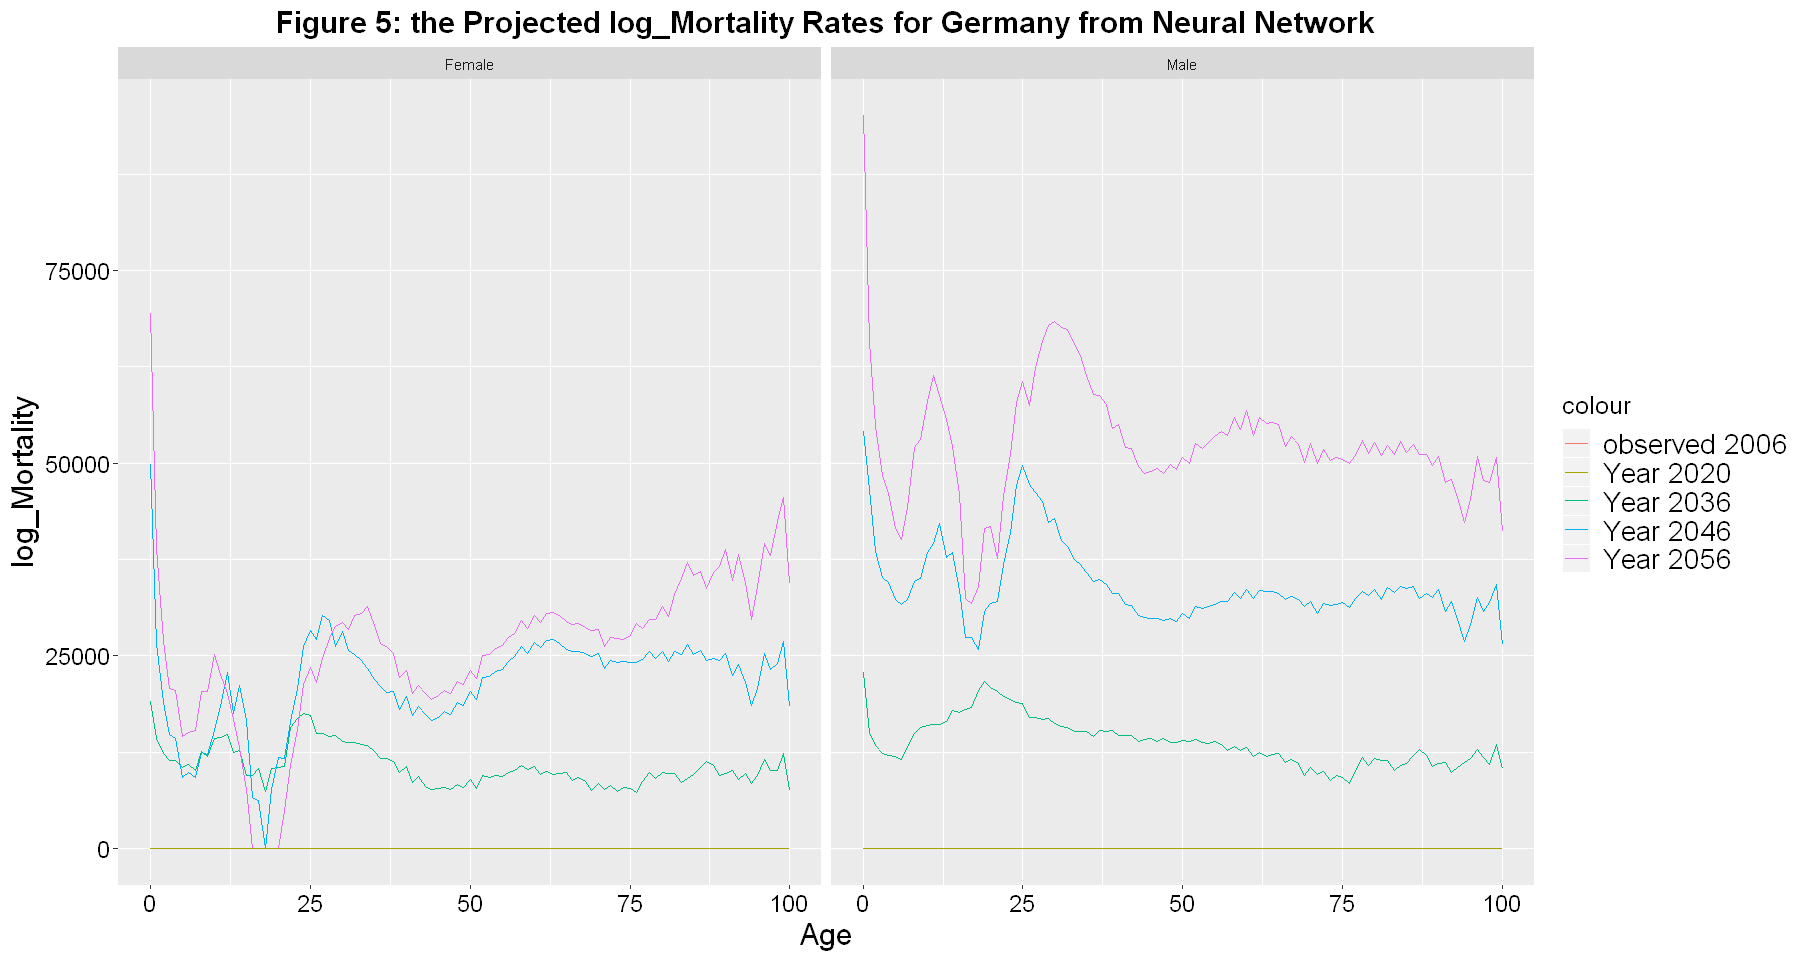

In [117]:
options(repr.plot.width = 15, repr.plot.height = 8)
projections %>% filter(Country_cat=="DEUT")%>% ggplot()+geom_line(aes(x=Age, y=log_mortality_2006,color="observed 2006",group=Gender_cat))+ 
geom_line(aes(x=Age, y=log_mortality_2036,color="Year 2036",group=Gender_cat))+ 
geom_line(aes(x=Age, y=log_mortality_2046,color="Year 2046",group=Gender_cat))+ 
geom_line(aes(x=Age, y=log_mortality_2056,color="Year 2056",group=Gender_cat))+ 
geom_line(aes(x=Age, y=log_mortality_2020,color="Year 2020",group=Gender))+facet_grid(. ~ Gender_cat)+
 ggtitle("Figure 5: the Projected log_Mortality Rates for Germany from Neural Network") +
  xlab("Age") + ylab("log_Mortality")+
 theme(plot.title = element_text(color="black", size=18, hjust = 0.5,face="bold" ),
     legend.title = element_text(color = "black", size = 15),
        legend.text = element_text(color = "black", size = 17),
       axis.text.x = element_text(face="plain", color="black", 
                           size=14, angle=0),
          axis.text.y = element_text(face="plain", color="black", 
                           size=14, angle=0),
        axis.title.x=element_text(size=18,face="plain"),
      axis.title.y=element_text(size=18,face="plain")
     ) 

plot the mortality projections for Germany

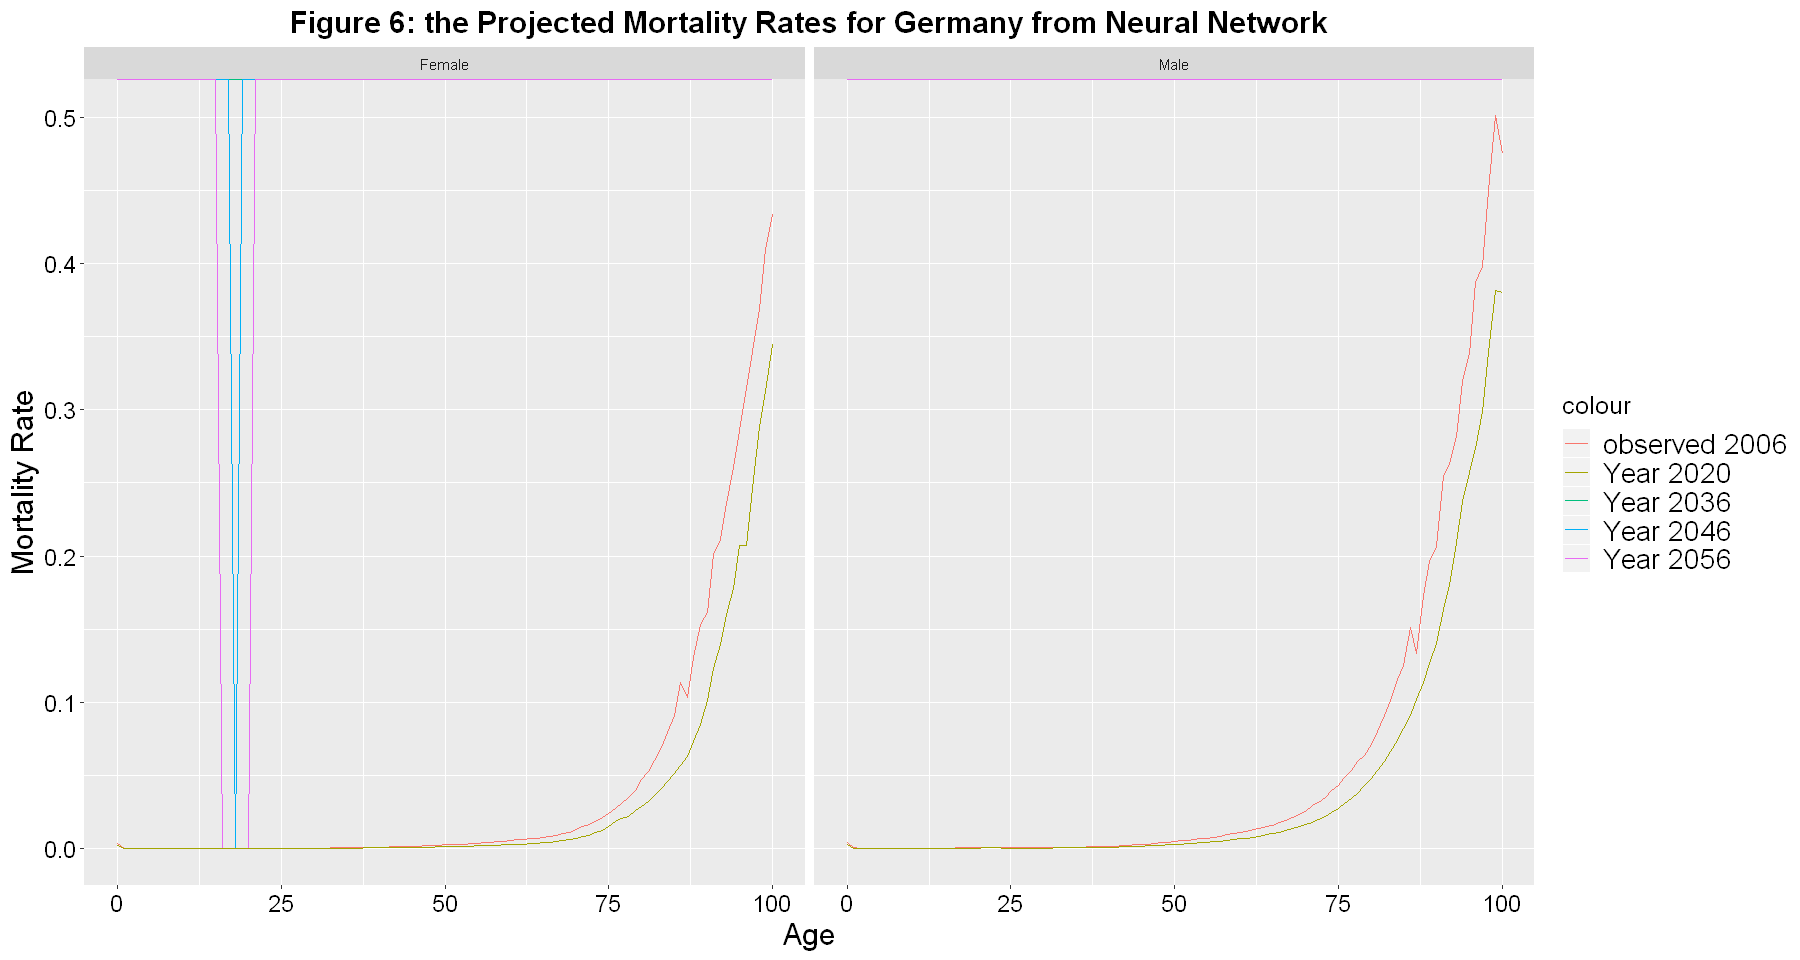

In [118]:
options(repr.plot.width = 15, repr.plot.height = 8)
projections %>% filter(Country_cat=="DEUT")%>% ggplot()+geom_line(aes(x=Age, y=observed_mortality_2006,color="observed 2006",group=Gender_cat))+ 
geom_line(aes(x=Age, y=mortality_2036,color="Year 2036",group=Gender_cat))+ 
geom_line(aes(x=Age, y=mortality_2046,color="Year 2046",group=Gender_cat))+ 
geom_line(aes(x=Age, y=mortality_2056,color="Year 2056",group=Gender_cat))+ 
geom_line(aes(x=Age, y=mortality_2020,color="Year 2020",group=Gender))+facet_grid(. ~ Gender_cat)+
  ggtitle("Figure 6: the Projected Mortality Rates for Germany from Neural Network") +
  xlab("Age") + ylab("Mortality Rate")+
 theme(plot.title = element_text(color="black", size=18, hjust = 0.5,face="bold" ),
     legend.title = element_text(color = "black", size = 15),
        legend.text = element_text(color = "black", size = 17),
       axis.text.x = element_text(face="plain", color="black", 
                           size=14, angle=0),
          axis.text.y = element_text(face="plain", color="black", 
                           size=14, angle=0),
        axis.title.x=element_text(size=18,face="plain"),
      axis.title.y=element_text(size=18,face="plain")
     ) 

### 6.2.2 Plausible Projections

In this subchapter, we show the projected mortality rates for Germany for future Years using the third best performing neural network.

In [120]:
path<-file.path(getwd(),results[3,1], "model.h5")
model <- load_model_hdf5(path)
log_mortality_2020 <-  model %>% predict(X_2020)
log_mortality_2036 <-  model %>% predict(X_2036)
log_mortality_2046<-  model %>% predict(X_2046)
log_mortality_2056 <-  model %>% predict(X_2056)

In [121]:
projections<- cbind(input,log_mortality_2020,log_mortality_2036,log_mortality_2046,log_mortality_2056)
projections<-projections %>% mutate(mortality_2020=exp(log_mortality_2020),
                                     mortality_2036=exp(log_mortality_2036),
                                    mortality_2046=exp(log_mortality_2046),
                                     mortality_2056=exp(log_mortality_2056),
                                      observed_mortality_2006=exp(log_mortality_2006)
                                      )


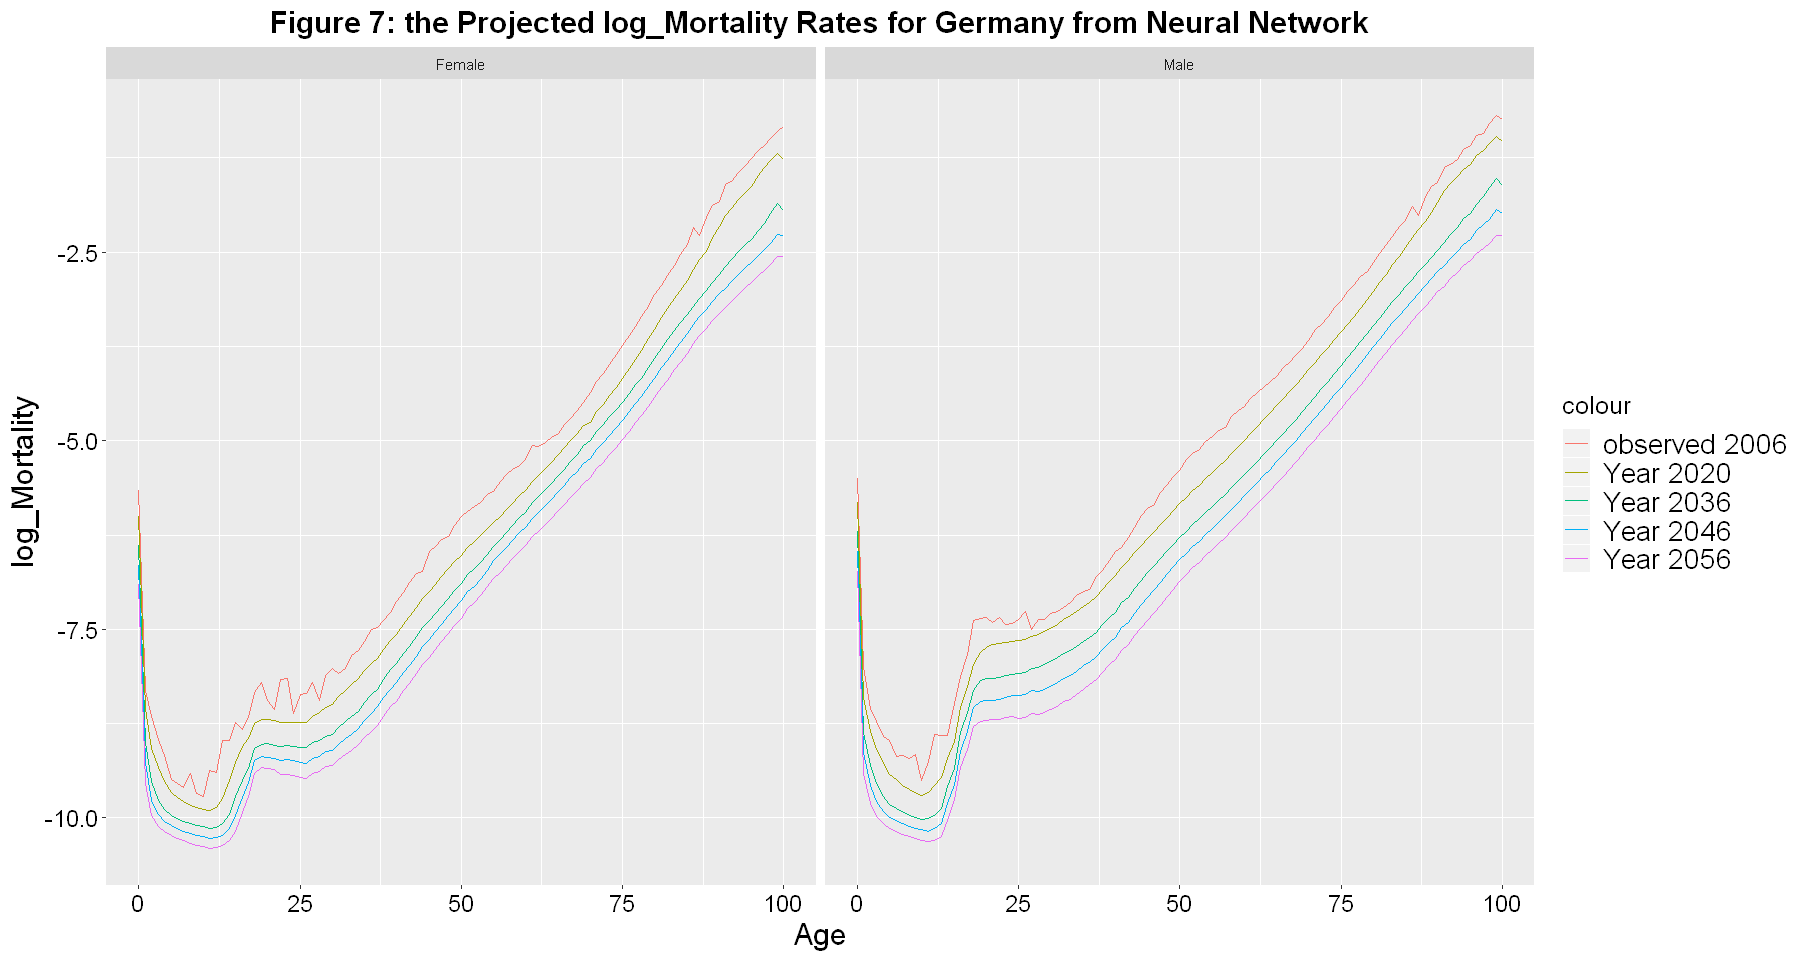

In [122]:
options(repr.plot.width = 15, repr.plot.height = 8)
projections %>% filter(Country_cat=="DEUT")%>% ggplot()+geom_line(aes(x=Age, y=log_mortality_2006,color="observed 2006",group=Gender_cat))+ 
geom_line(aes(x=Age, y=log_mortality_2036,color="Year 2036",group=Gender_cat))+ 
geom_line(aes(x=Age, y=log_mortality_2046,color="Year 2046",group=Gender_cat))+ 
geom_line(aes(x=Age, y=log_mortality_2056,color="Year 2056",group=Gender_cat))+ 
geom_line(aes(x=Age, y=log_mortality_2020,color="Year 2020",group=Gender))+facet_grid(. ~ Gender_cat)+
 ggtitle("Figure 7: the Projected log_Mortality Rates for Germany from Neural Network") +
  xlab("Age") + ylab("log_Mortality")+
 theme(plot.title = element_text(color="black", size=18, hjust = 0.5,face="bold" ),
     legend.title = element_text(color = "black", size = 15),
        legend.text = element_text(color = "black", size = 17),
       axis.text.x = element_text(face="plain", color="black", 
                           size=14, angle=0),
          axis.text.y = element_text(face="plain", color="black", 
                           size=14, angle=0),
        axis.title.x=element_text(size=18,face="plain"),
      axis.title.y=element_text(size=18,face="plain")
     ) 

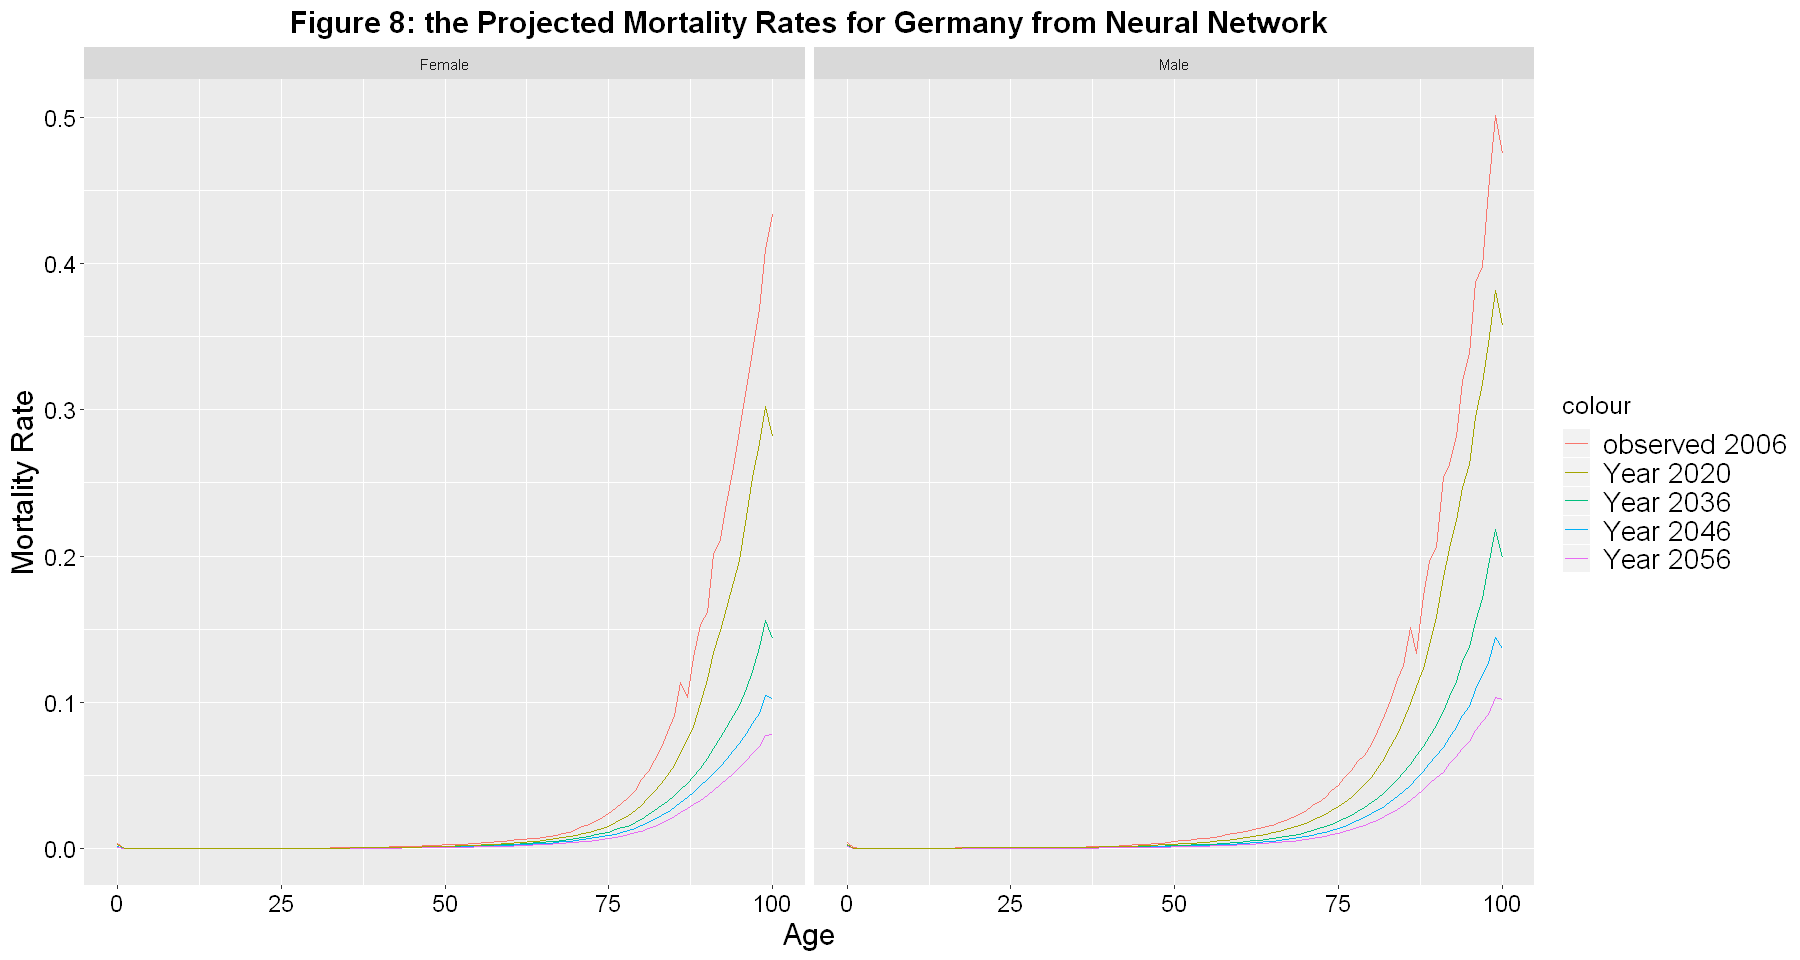

In [123]:
options(repr.plot.width = 15, repr.plot.height = 8)
projections %>% filter(Country_cat=="DEUT")%>% ggplot()+geom_line(aes(x=Age, y=observed_mortality_2006,color="observed 2006",group=Gender_cat))+ 
geom_line(aes(x=Age, y=mortality_2036,color="Year 2036",group=Gender_cat))+ 
geom_line(aes(x=Age, y=mortality_2046,color="Year 2046",group=Gender_cat))+ 
geom_line(aes(x=Age, y=mortality_2056,color="Year 2056",group=Gender_cat))+ 
geom_line(aes(x=Age, y=mortality_2020,color="Year 2020",group=Gender))+facet_grid(. ~ Gender_cat)+
  ggtitle("Figure 8: the Projected Mortality Rates for Germany from Neural Network") +
  xlab("Age") + ylab("Mortality Rate")+
 theme(plot.title = element_text(color="black", size=18, hjust = 0.5,face="bold" ),
     legend.title = element_text(color = "black", size = 15),
        legend.text = element_text(color = "black", size = 17),
       axis.text.x = element_text(face="plain", color="black", 
                           size=14, angle=0),
          axis.text.y = element_text(face="plain", color="black", 
                           size=14, angle=0),
        axis.title.x=element_text(size=18,face="plain"),
      axis.title.y=element_text(size=18,face="plain")
     ) 

# 6. Predict Mortality on Test Data With Lee-Carter Model <a name="6_predictLC"></a>

In this chapter, we train the Lee-Carter model on the same training data (mortality rates for 9 countries from 1956 to 2005) as with neural network and make predictions on the mortality rates for the test data (mortality rates for 9 countries from 2006 to 2016). It has to be mentioned that the training and test of the Lee-Carter model are performed separately per country-gender group.

The main body of the code used in this chapter is from the article "Lee and Carter go Machine Learning: Recurrent Neural Networks" by Richmann und Würthrich (2019). We have made certain amendments to the code in order to get the predicted mortality rates on the test set.




In [124]:

data <- fread(file="mortality.csv")

data$Gender <- as.factor(data$Gender)


country <- c("JPN", "USA", "ESP", "ITA", "CHE", "FRATNP", "DNK", "POL", "DEUT")
gender <- c("Male", "Female")
Year.min <- 1956
ObsYear <- 2005

lc_list<- list()

for(c in country){
    lc_within <- list()
  for(g in gender){
    train <- subset(data, Year >= Year.min & Year<=ObsYear &  Gender == g & Country == c)
    ## Fit Lee Carter via SVD to the selected country and extrapolate with Random Walk with Drift
    train[,ax:= mean(log_mortality), by = (Age)]
    train[,mx_adj:= log_mortality-ax]  
    rates_mat <- as.matrix(train %>% dcast.data.table(Age~Year, value.var = "mx_adj", sum))[,-1]
    svd_fit <- svd(rates_mat)
    ax <- train[,unique(ax)]
    bx <- svd_fit$u[,1]*svd_fit$d[1]
    kt <- svd_fit$v[,1]
    c1 <- mean(kt)
    c2 <- sum(bx)
    ax <- ax+c1*bx
    bx <- bx/c2
    kt <- (kt-c1)*c2
    
    ## extrapolation and forecast
    vali <- subset(data, Year>ObsYear &  Gender == g & Country == c)
    t_forecast <- vali[,unique(Year)] %>% length()
    forecast_kt  =kt %>% forecast::rwf(t_forecast, drift = T)
    kt_forecast = forecast_kt$mean
    
    # in-sample and out-of-sample analysis    
    fitted = (ax+(bx)%*%t(kt)) %>% melt
    train$pred_LC_svd = fitted$value %>% exp
    fitted_vali = (ax+(bx)%*%t(kt_forecast)) %>% melt
    vali$pred_LC_svd =   fitted_vali$value %>% exp
  
  
    lc_within[[g]] <- vali
  }
  
  lc_list[[c]] <- rbindlist(lc_within)

}

lc_prediction<- rbindlist(lc_list)

In [125]:
dim(lc_prediction)

[1] 19594     6

In [126]:
head(lc_prediction)

Country,year,Gender,Age,log_mortality,pred_LC_svd
JPN,2006,Male,0,-5.859384,0.0028000527
JPN,2006,Male,1,-7.756387,0.0004715678
JPN,2006,Male,2,-8.170064,0.0002635938
JPN,2006,Male,3,-8.611504,0.0002073630
JPN,2006,Male,4,-8.633727,0.0001685065
JPN,2006,Male,5,-8.925161,0.0001506341


# 7 Compare Lee-Carter and Neural Network Mortality Predictions <a name="7_compare"></a>

To faciliate the comparison of the prediction performance of the two models, we merge the two predictions from Lee-Carter and Neural Nets on the test set from 2006 to 2016. The merged dataset is called "predictions". It has to be noted that the neural network model is estimated using data points across all 9 countries and both genders, whereas the Lee-Carter is estimated by country-gender group separately

In [127]:
predictions <- inner_join(NN_prediction,lc_prediction,by=c("Country","Year","Gender","Age"))

predictions<- predictions %>% 
  rename(
    observed_mortality= mortality,
      lc_mortality=pred_LC_svd
  )

select the relevant columns 

In [128]:
col_vector <-c('Country',
 'Year',
 'Gender',
 'Age',
 'observed_mortality',
 'NN_mortality',
 'lc_mortality')
 
predictions<-select(predictions, one_of(col_vector))

In [129]:
sample_n(predictions,10)



Country,year,Gender,Age,observed_mortality,NN_mortality,lc_mortality
ITA,2010,Male,27,0.000542,0.0005983946,0.0008120710
ESP,2015,Female,91,0.156702,0.1449698421,0.1939060222
DNK,2012,Male,79,0.062545,0.0609232876,0.0782616378
FRATNP,2014,Female,48,0.001817,0.0016466880,0.0016084680
USA,2008,Male,87,0.134868,0.1417533354,0.1451807696
DEUT,2014,Male,44,0.001748,0.0018413202,0.0025849154
JPN,2008,Male,2,0.000226,0.0002339116,0.0002385298
ESP,2013,Female,76,0.017102,0.0180771204,0.0187043923
FRATNP,2014,Female,59,0.004137,0.0036252785,0.0032116383
POL,2012,Male,83,0.109007,0.1097917475,0.1303243559


## 7.1 Graphical Analysis of the Predictions For the Mortality Rates Per Country, Year and Gender

Using the following code, we can compare the predicted mortality rates from Lee-Carter Model and the neural networks we have trained. One can choose different country and Year combinations to see how the predicted mortality rates by the two models (Lee-Carter and neural networks) compare with observed mortality rates.

We only show the comparison of the two models for the Year of 2014. The readers can set the Year parameter in the code for plotting (filter(Year==2014)) to any value between 2006 and 2016, in order to see the comparison for any other Year. 


In [130]:
forecast<- predictions %>% gather('observed_mortality',
'NN_mortality',
'lc_mortality',key="Models",value="mortality"
) 

forecast$Models <- as.factor(forecast$Models)

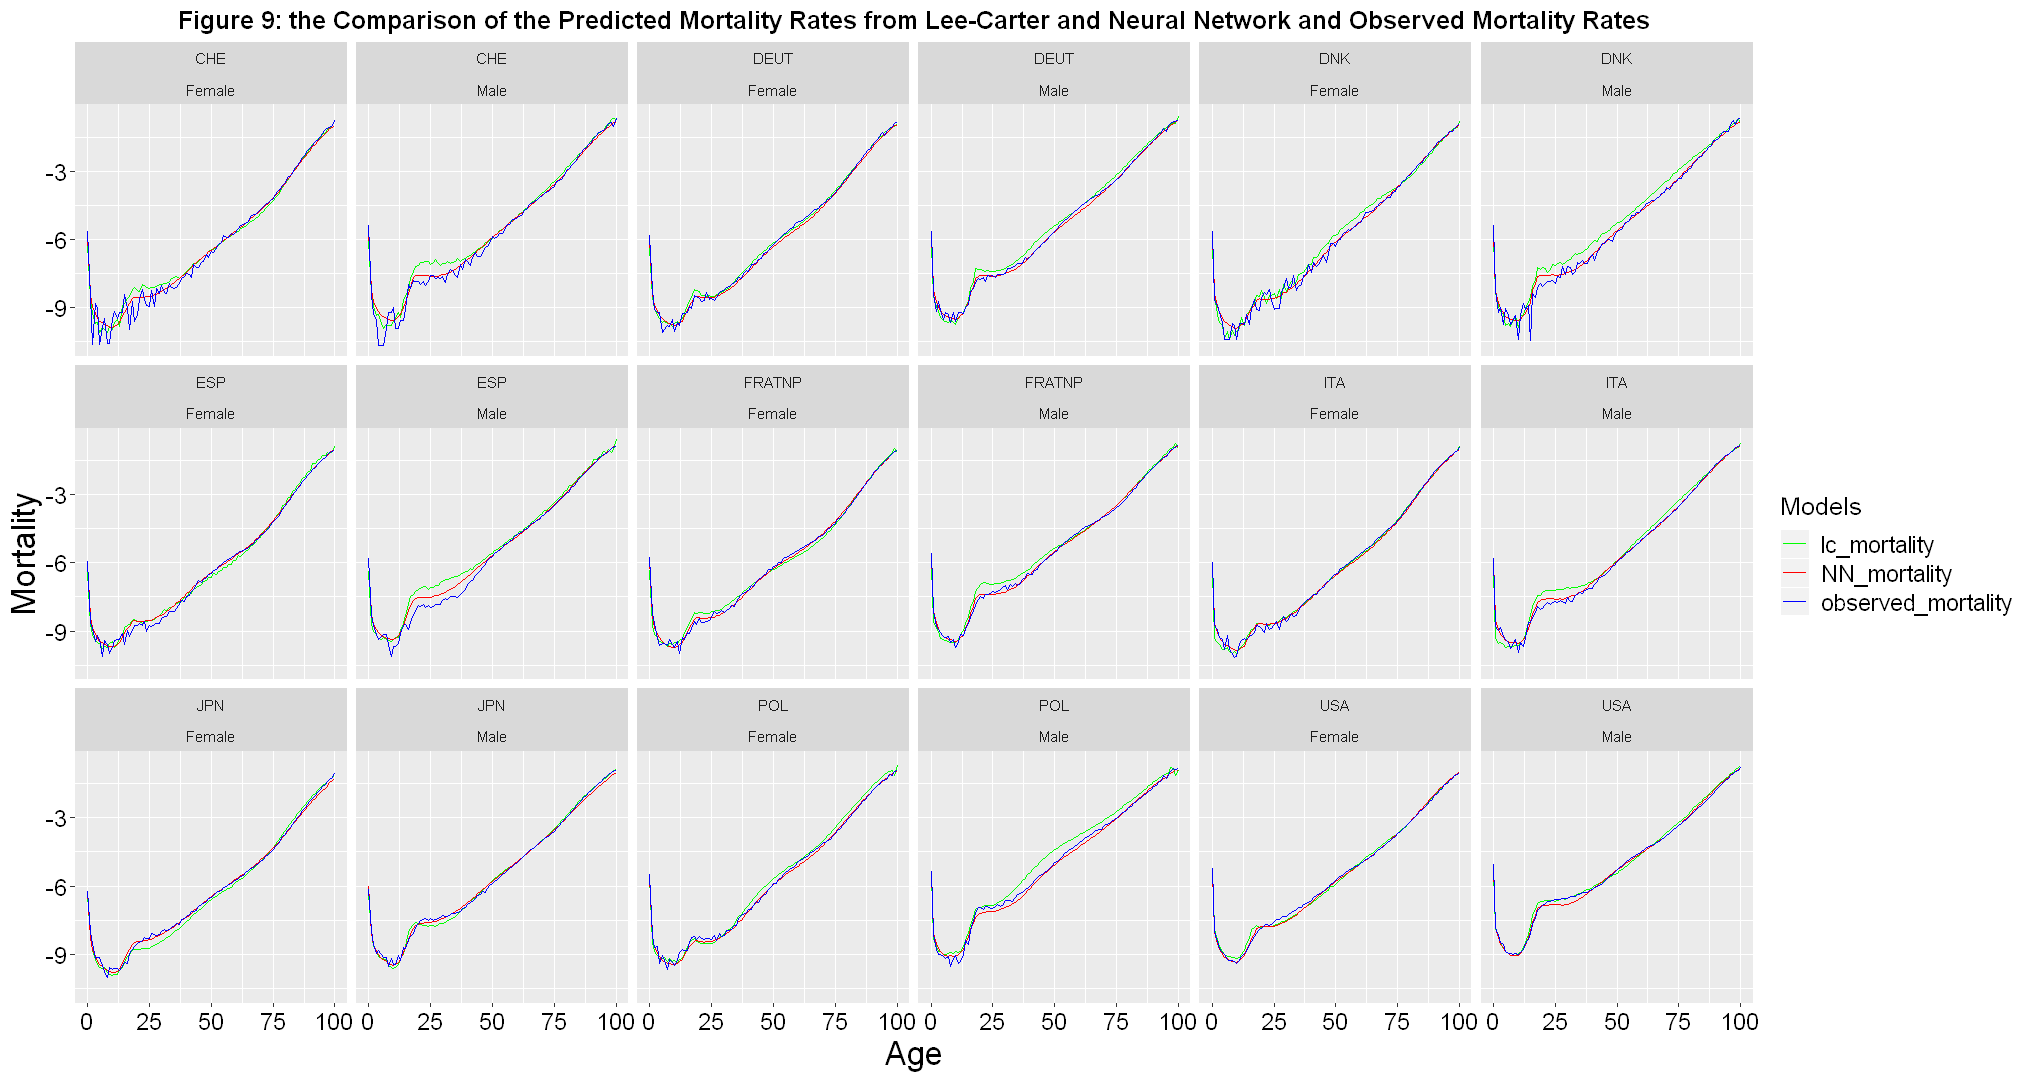

In [131]:
my_colors <- c( "green", "red","blue")            # Create vector of colors

names(my_colors) <- levels(factor(levels(forecast$Models))) 

my_scale <- scale_color_manual(name = "Models", values = my_colors) 

options(repr.plot.width = 17, repr.plot.height = 9)

forecast %>% filter(Year==2014) %>% mutate(
  log_mortality = log(mortality)
  )  %>% ggplot()+geom_line(aes(Age, log_mortality,color=Models)) +facet_wrap(~Country+Gender,ncol=6)+
  ggtitle("Figure 9: the Comparison of the Predicted Mortality Rates from Lee-Carter and Neural Network and Observed Mortality Rates") +
  xlab("Age") + ylab("Mortality")+ my_scale +
 theme(plot.title = element_text(color="black", size=15, hjust = 0.5,face="bold" ),
     legend.title = element_text(color = "black", size = 15),
        legend.text = element_text(color = "black", size = 14),
       axis.text.x = element_text(face="plain", color="black", 
                           size=14, angle=0),
          axis.text.y = element_text(face="plain", color="black", 
                           size=14, angle=0),
        axis.title.x=element_text(size=20,face="plain"),
      axis.title.y=element_text(size=20,face="plain")
     ) 


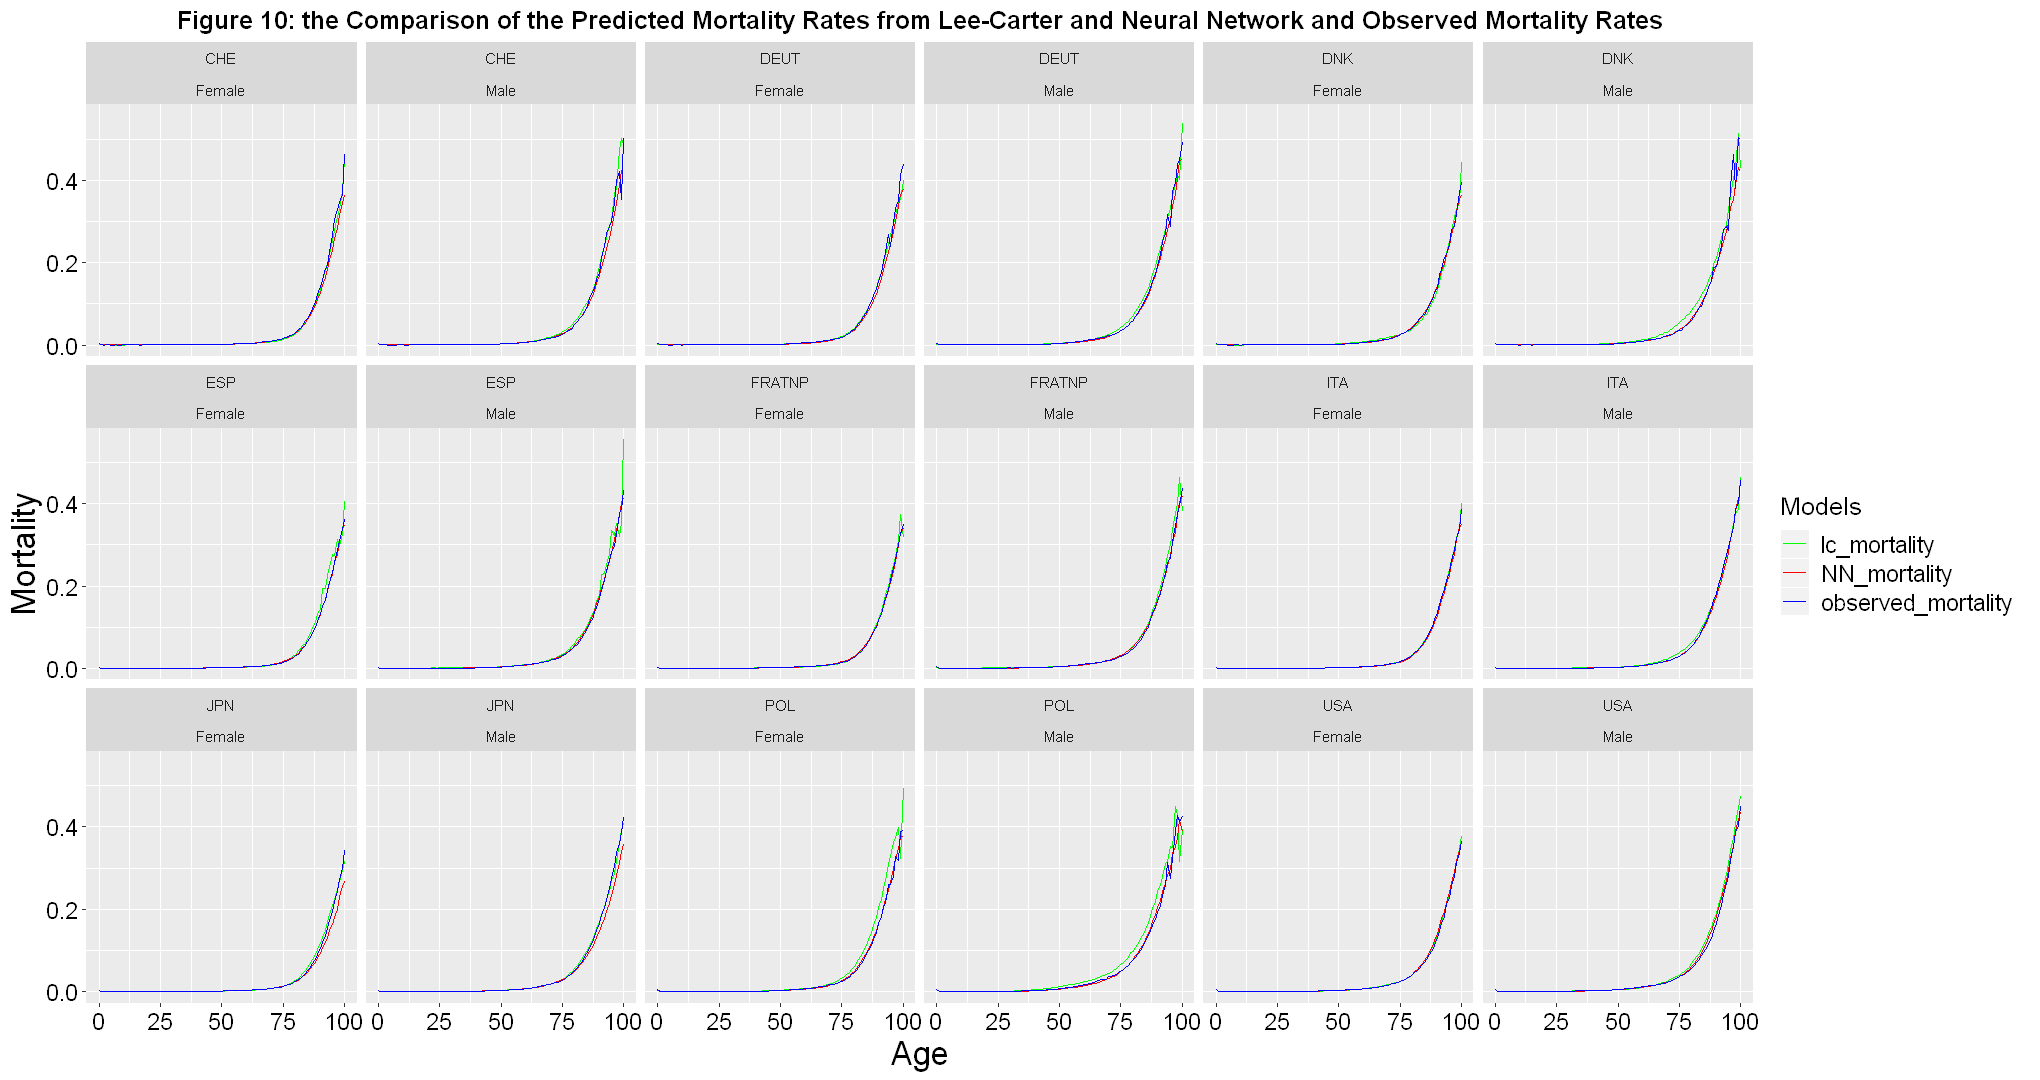

In [132]:

options(repr.plot.width = 17, repr.plot.height = 9)

forecast %>% filter(Year==2014) %>% ggplot()+geom_line(aes(Age, mortality,color=Models)) +facet_wrap(~Country+Gender,ncol=6)+
  ggtitle("Figure 10: the Comparison of the Predicted Mortality Rates from Lee-Carter and Neural Network and Observed Mortality Rates") +
  xlab("Age") + ylab("Mortality")+my_scale +
 theme(plot.title = element_text(color="black", size=15, hjust = 0.5,face="bold" ),
     legend.title = element_text(color = "black", size = 15),
        legend.text = element_text(color = "black", size = 14),
       axis.text.x = element_text(face="plain", color="black", 
                           size=14, angle=0),
          axis.text.y = element_text(face="plain", color="black", 
                           size=14, angle=0),
        axis.title.x=element_text(size=20,face="plain"),
      axis.title.y=element_text(size=20,face="plain")
     ) 


## 7.2 Quantitative Analysis of Mean Squared Error

In this section, we compare the prediction performance of the neural networks and the Lee-Carter predictions by evaluating the metrics (mean squared error). First we calculate the squared error for each observation of the predictions. Afterwards we utilize the "group_by" functionality in order to calculate the group-wide mean squared error for each country-gender group over all the Years.

It is worth mentioning that for the countries chosen in our use case Lee-Carter model already performs very well. We refer the reader to Richman and Wüthrich (2018) where the performance of Lee-Carter model is shown for 38 different countries. Nevertheless, using our hyperparameter search, we manage to train neural networks that are able to beat Lee-Carter in two regards: overall mean squred error on the test set as shown in chapter 7.2.1, and the number of country-gender groups where Neural Network has lower mean squred errors, as shown in chapter 7.2.2

In [133]:
sample_n(predictions,9)

Country,year,Gender,Age,observed_mortality,NN_mortality,lc_mortality
POL,2008,Female,16,0.000364,2.138287e-04,2.319439e-04
ITA,2012,Female,90,0.144597,1.337946e-01,1.386140e-01
POL,2011,Male,61,0.019288,1.773785e-02,2.511162e-02
DEUT,2015,Male,25,0.000476,4.756004e-04,5.945583e-04
CHE,2011,Female,90,0.140755,1.369837e-01,1.406405e-01
JPN,2010,Female,68,0.006432,6.670389e-03,6.788139e-03
JPN,2006,Female,26,0.000338,2.909315e-04,2.380274e-04
ITA,2012,Male,52,0.003239,3.354034e-03,3.544023e-03
JPN,2008,Male,10,0.000071,8.744241e-05,8.428806e-05


In [134]:
prediction_error <- predictions %>% mutate(
  NN_error = (NN_mortality-observed_mortality)^2,
   lc_error = (lc_mortality-observed_mortality)^2,
)


### 7.2.1 Compare MSE for Neural Networks and Lee-Carter Models 

In [135]:
head(prediction_error)

Country,year,Gender,Age,observed_mortality,NN_mortality,lc_mortality,NN_error,lc_error
CHE,2006,Female,0,0.003985,3.471949e-03,2.876086e-03,2.632216e-07,1.229690e-06
CHE,2006,Female,1,0.000337,2.790873e-04,2.617378e-04,3.353880e-09,5.664406e-09
CHE,2006,Female,2,0.000085,1.591549e-04,1.348294e-04,5.498955e-09,2.482967e-09
CHE,2006,Female,3,0.000141,1.207752e-04,9.034154e-05,4.090423e-10,2.566280e-09
CHE,2006,Female,4,0.000112,1.011065e-04,9.059505e-05,1.186690e-10,4.581718e-10
CHE,2006,Female,5,0.000139,8.499936e-05,6.100183e-05,2.916069e-09,6.083715e-09


In [136]:
mse_NN<-mean(prediction_error$NN_error)
cat("The mean squared error of the Neural Network predictions on the test set is ", mse_NN)


The mean squared error of the Neural Network predictions on the test set is  9.158033e-05

In [137]:
mse_lc<-mean(prediction_error$lc_error)
cat("The mean squared error of the lee_carter predictions on the test set is ", mse_lc)

The mean squared error of the lee_carter predictions on the test set is  0.0001251259

### 7.2.2 Compare MSE for Neural Networks and Lee-Carter Models by Country-Gender Group

In [138]:
### Calculate the the mean squared error per country and gender.
mse <- prediction_error %>% 
  group_by(Country,Gender) %>% 
  summarize(mse_NN=mean(NN_error),
            mse_lc=mean(lc_error,na.rm=TRUE))

In [139]:
mse %>% ungroup()

Country,Gender,mse_NN,mse_lc
CHE,Female,1.465979e-04,8.064493e-05
CHE,Male,1.858336e-04,1.823052e-04
DEUT,Female,1.290387e-04,8.318317e-05
DEUT,Male,1.065868e-04,1.115609e-04
DNK,Female,6.290338e-05,8.566356e-05
DNK,Male,3.539380e-04,3.834106e-04
ESP,Female,2.241446e-05,6.919801e-05
ESP,Male,4.092471e-05,2.033477e-04
FRATNP,Female,2.927603e-05,4.276970e-05
FRATNP,Male,5.463496e-05,7.958913e-05


In [140]:
mse %>% ungroup()%>%filter(mse_NN<mse_lc)

Country,Gender,mse_NN,mse_lc
DEUT,Male,1.065868e-04,1.115609e-04
DNK,Female,6.290338e-05,8.566356e-05
DNK,Male,3.539380e-04,3.834106e-04
ESP,Female,2.241446e-05,6.919801e-05
ESP,Male,4.092471e-05,2.033477e-04
FRATNP,Female,2.927603e-05,4.276970e-05
FRATNP,Male,5.463496e-05,7.958913e-05
ITA,Male,3.619865e-05,4.942109e-05
POL,Female,3.363432e-05,3.239788e-04
POL,Male,1.002263e-04,3.563289e-04


In [141]:
better<-mse %>% ungroup()%>%filter(mse_NN<mse_lc) %>% count()%>% .[[1,1]]
cat("The predictions made by neural network model perform better than those of the lee-Carter Model in", better, "Out of 18 Country-Gender Groups of mortality rates")

The predictions made by neural network model perform better than those of the lee-Carter Model in 12 Out of 18 Country-Gender Groups of mortality rates

In [142]:

mse %>% ungroup()%>%filter(mse_NN>mse_lc)

Country,Gender,mse_NN,mse_lc
CHE,Female,1.465979e-04,8.064493e-05
CHE,Male,1.858336e-04,1.823052e-04
DEUT,Female,1.290387e-04,8.318317e-05
ITA,Female,2.432748e-05,1.169243e-05
JPN,Female,1.075894e-04,4.705808e-05
JPN,Male,1.612694e-04,2.499710e-05


In [143]:
worse<-mse %>% ungroup()%>%filter(mse_NN>mse_lc) %>% count()%>% .[[1,1]]
cat("The predictions made by neural network model perform worse than those of the lee-Carter Model in", worse, "Out of 18 Country-Gender Groups of mortality rates ")


The predictions made by neural network model perform worse than those of the lee-Carter Model in 6 Out of 18 Country-Gender Groups of mortality rates 